# Experiments on hyperparameters

In [1]:
import sys
import os

# Add the absolute path to 'src' folder
sys.path.append(os.path.abspath("src"))

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import random
from typing import List
from layer import Layer
from linear import Linear
from activations import ActivationReLU, ActivationSigmoid
from sequential import Sequential
from utils import mean_squared_error, InformantStrategy
from data import load_data
from pso import ParticleSwarmOptimisation, AccelerationCoefficients

/Users/antoine/delivery/HeriotWatt/BIC/Concrete_ANN_PSO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OS:  posix
Running 64 iterations in parallel using 8 CPU cores...
Run 6 completed: Final Loss = 0.00767, Train Acc = 84.14%, Test Acc = 84.30%
Run 8 completed: Final Loss = 0.00677, Train Acc = 84.96%, Test Acc = 86.54%
Run 4 completed: Final Loss = 0.01512, Train Acc = 77.40%, Test Acc = 78.14%
Run 2 completed: Final Loss = 0.00766, Train Acc = 84.36%, Test Acc = 85.49%
Run 3 completed: Final Loss = 0.00698, Train Acc = 84.81%, Test Acc = 85.71%
Run 1 completed: Final Loss = 0.00924, Train Acc = 82.62%, Test Acc = 82.47%
Run 7 completed: Final Loss = 0.01480, Train Acc = 77.99%, Test Acc = 79.09%
Run 5 completed: Final Loss = 0.00862, Train Acc = 83.01%, Test Acc = 83.58%
Run 9 completed: Final Loss = 0.00720, Train Acc = 84.40%, Test Acc = 85.61%
Run 12 completed: Final Loss = 0.01623, Train Acc = 76.51%, Test Acc = 77.63%
Run 10 completed: Final Loss = 0.00688, Train Acc = 85.30%, Test Acc = 86.36%
Run 13 completed: Final Loss = 0.00755, Train Acc = 84.09%, Test Acc = 84.78%
Run 14 

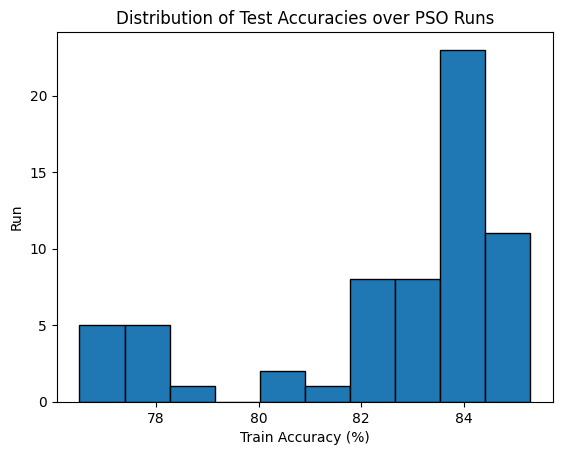

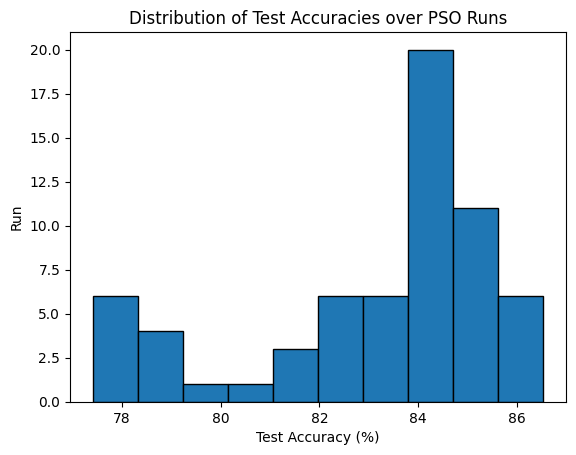

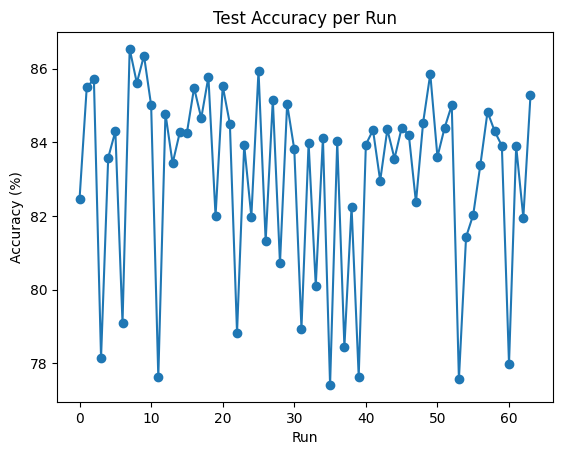

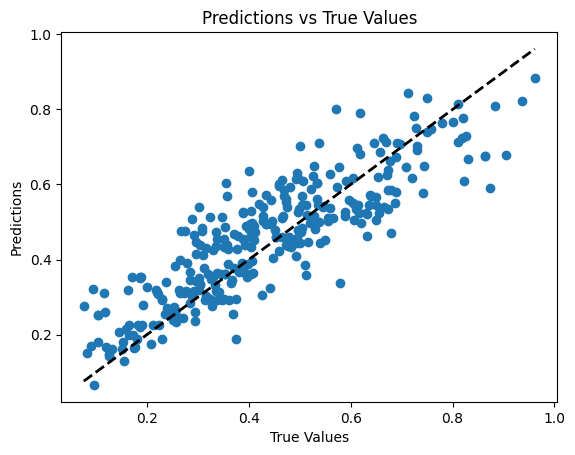

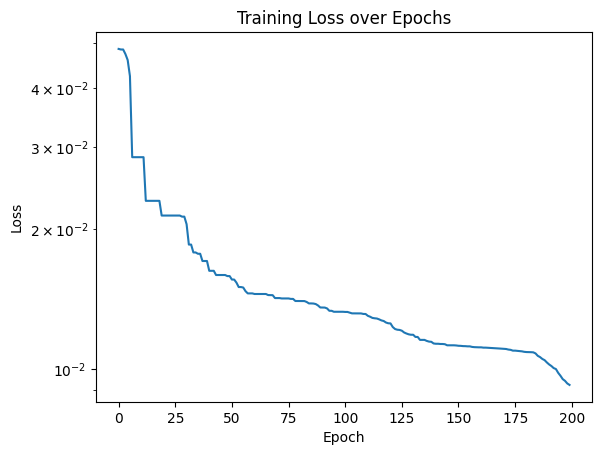

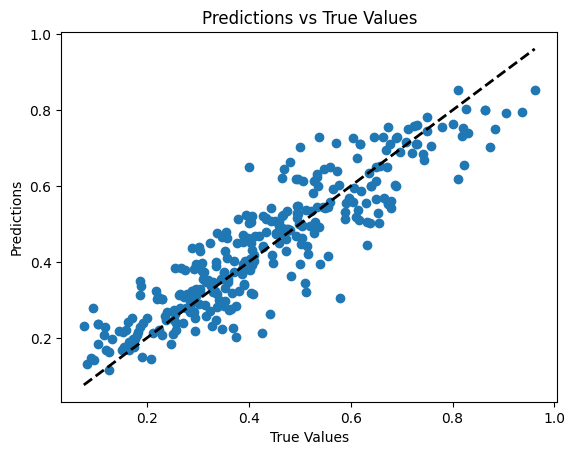

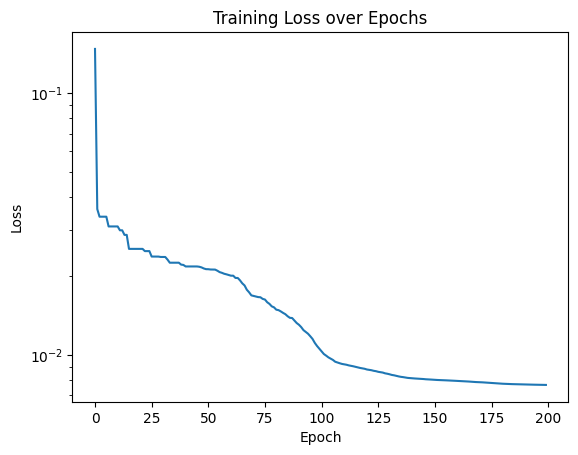

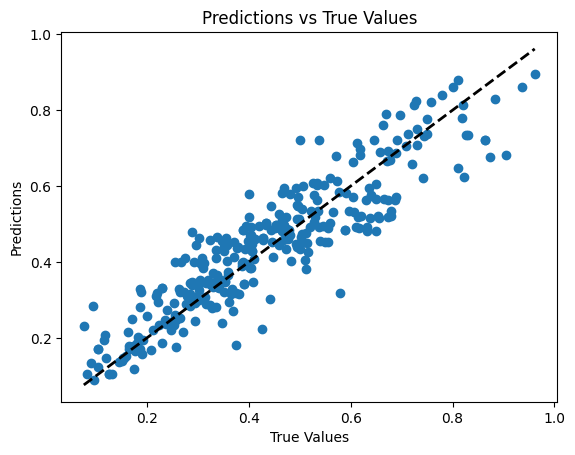

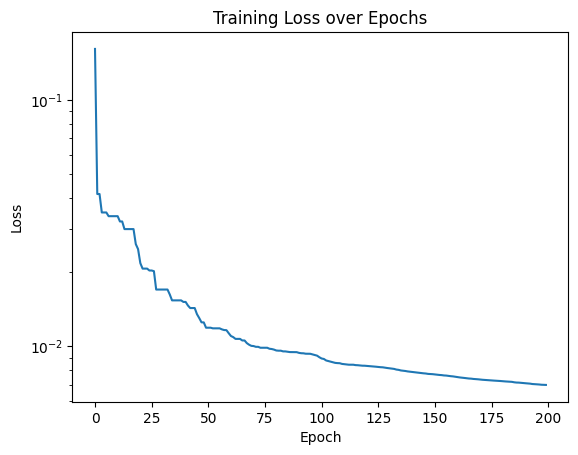

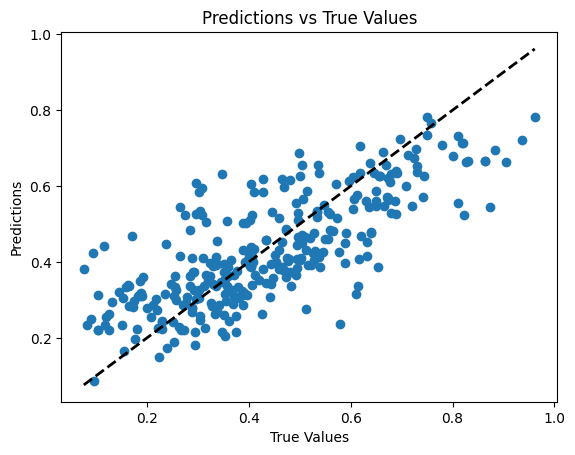

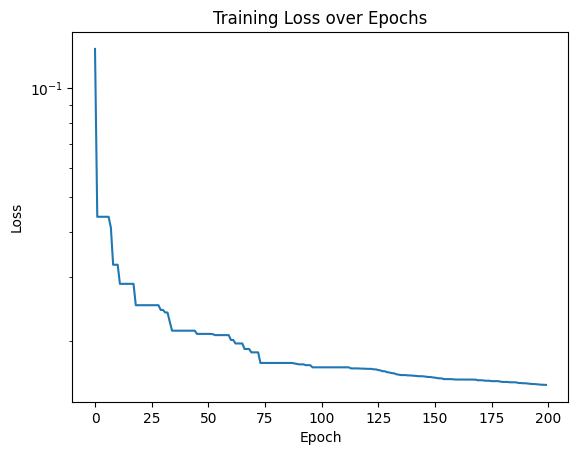

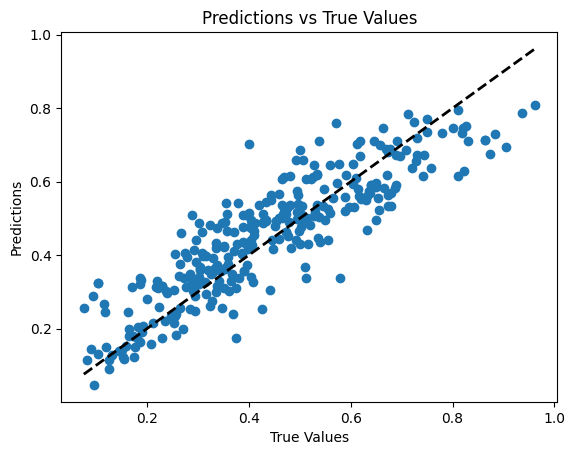

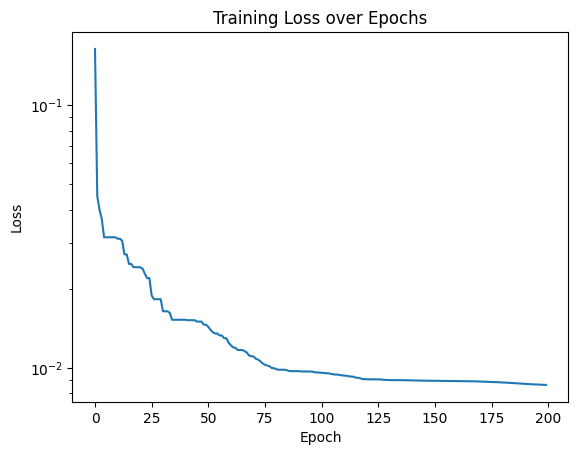

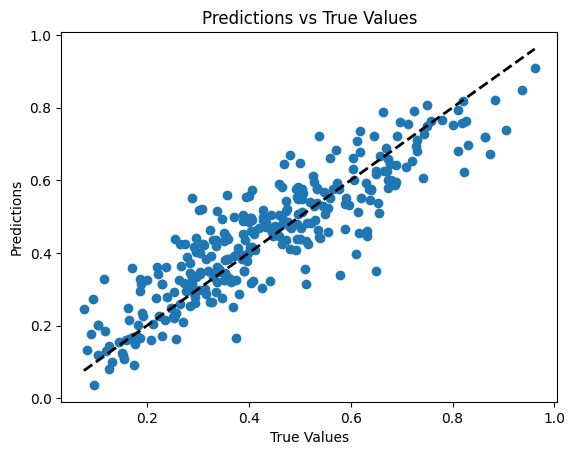

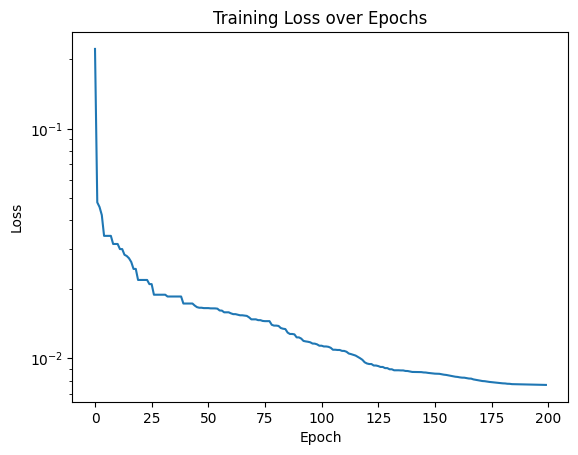

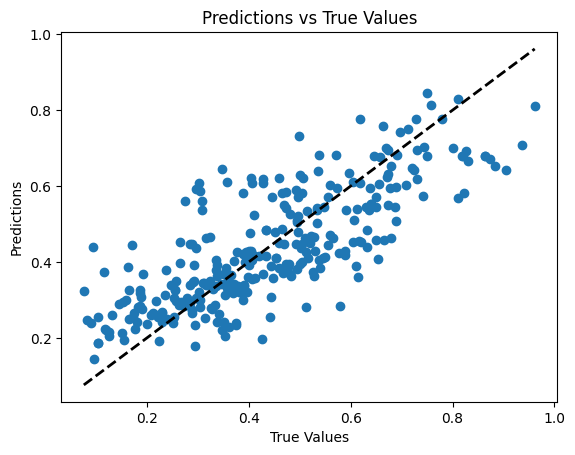

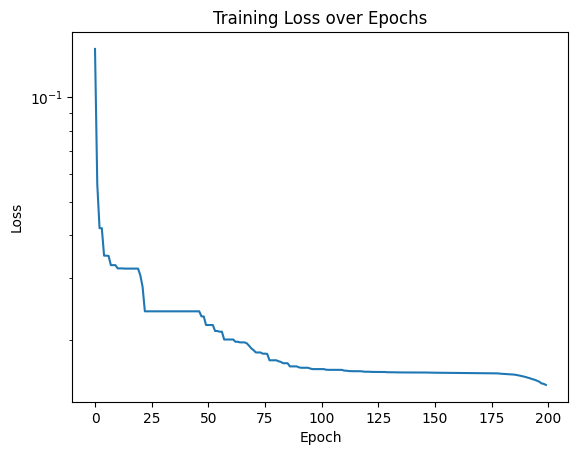

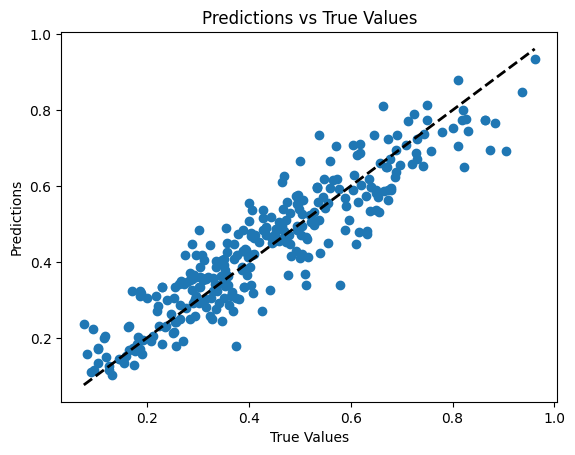

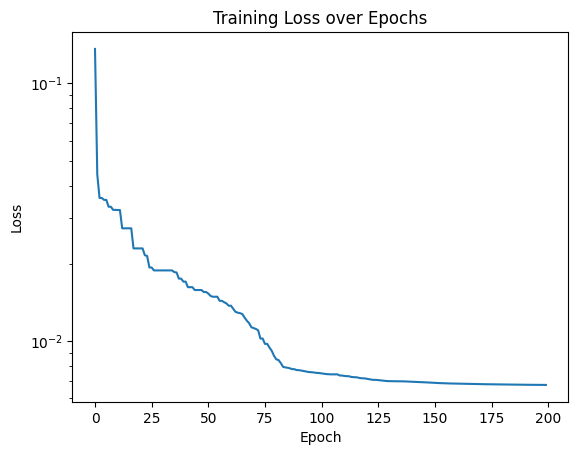

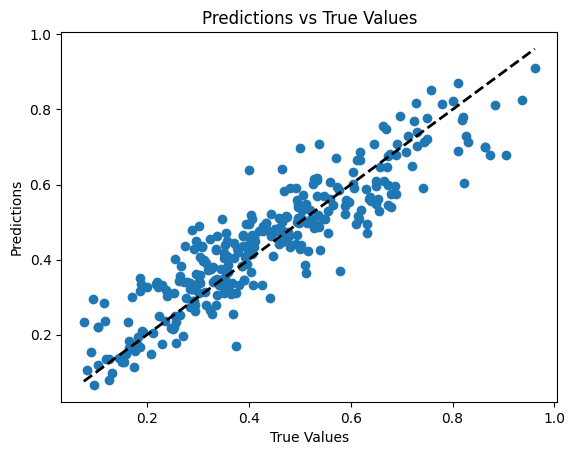

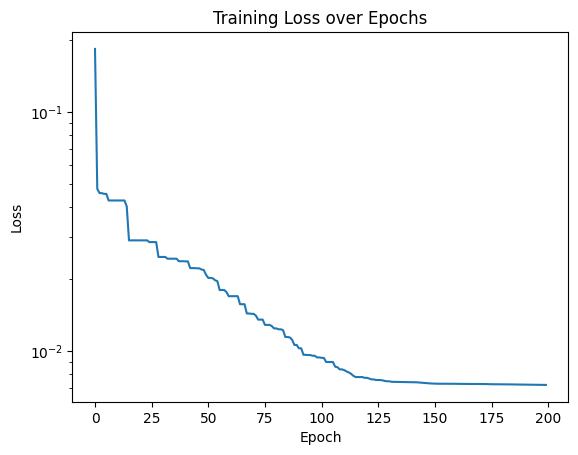

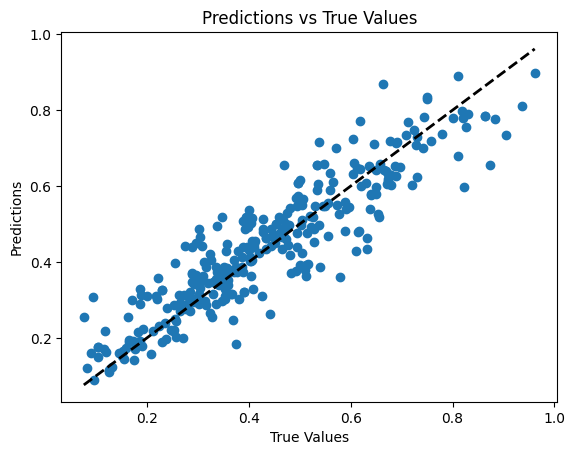

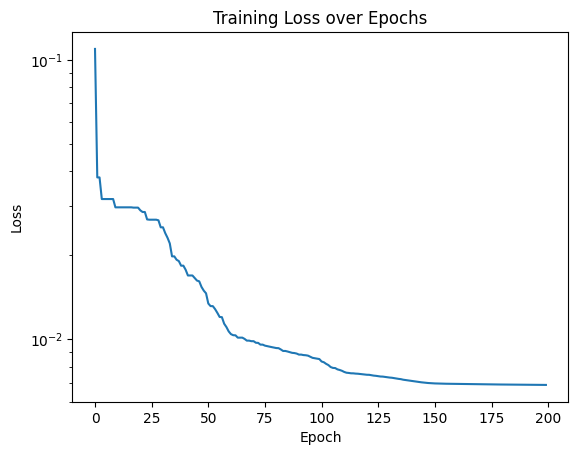

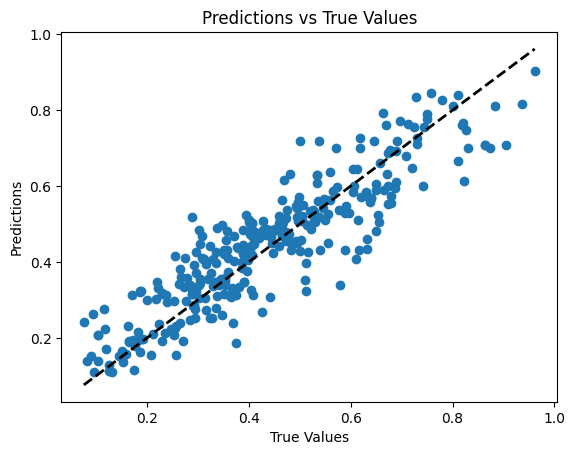

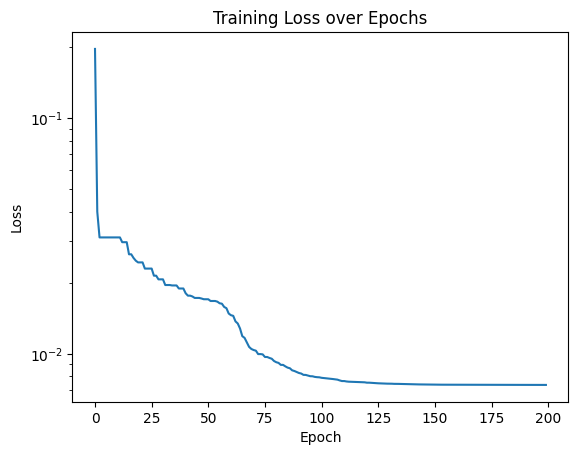

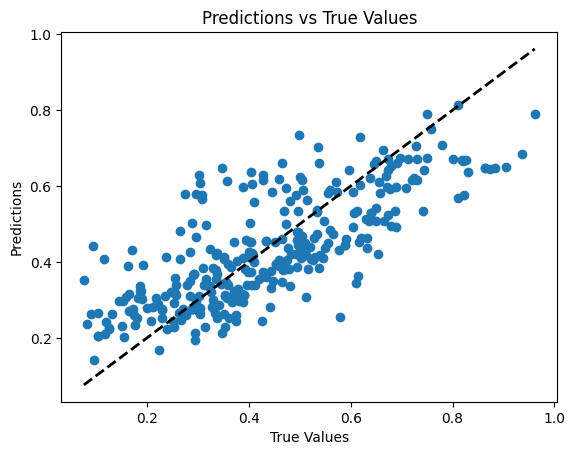

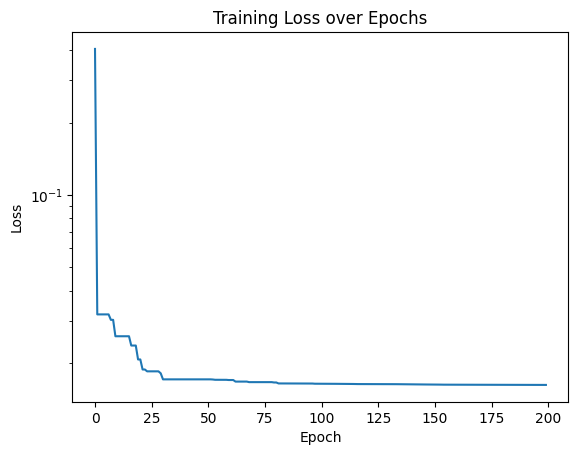

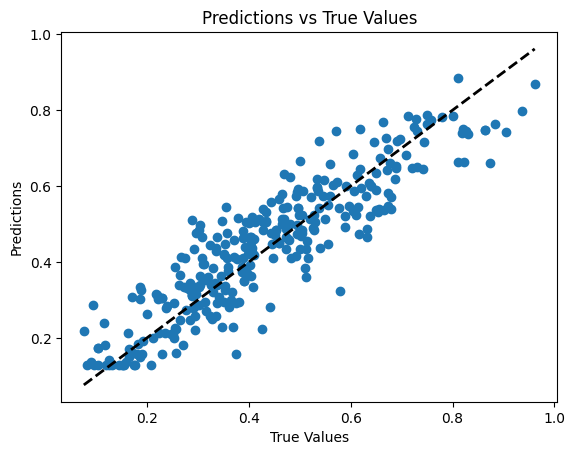

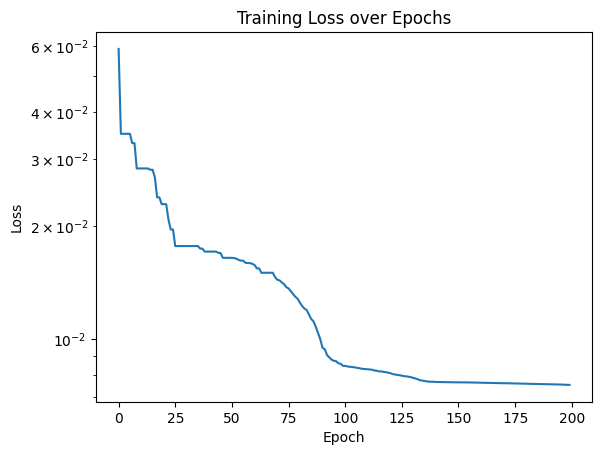

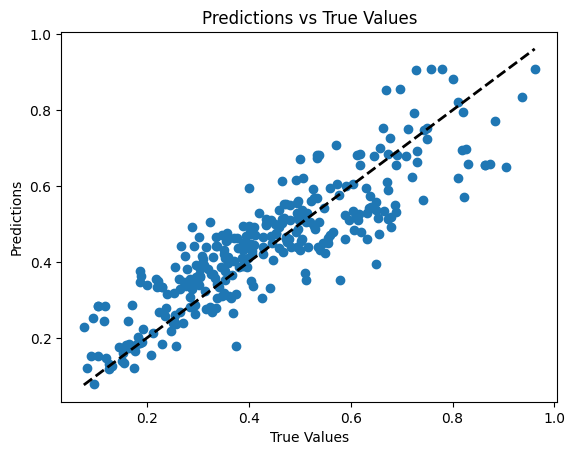

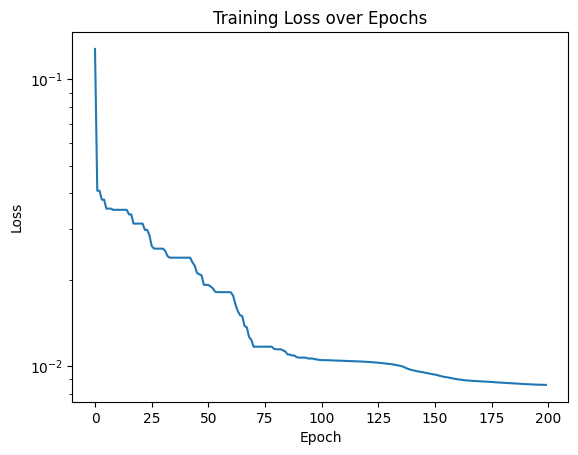

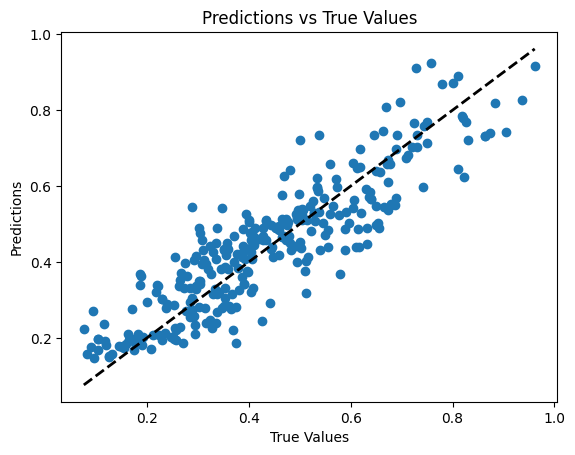

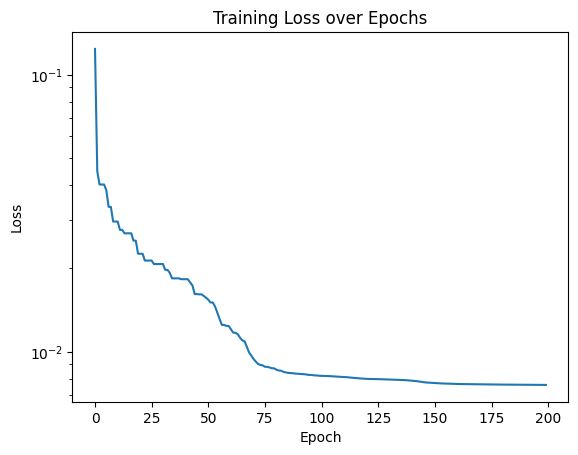

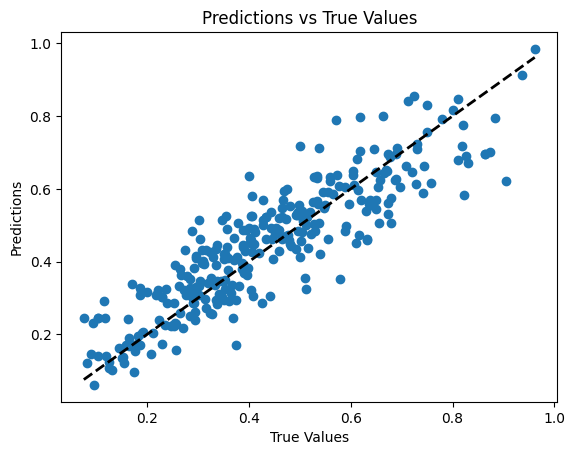

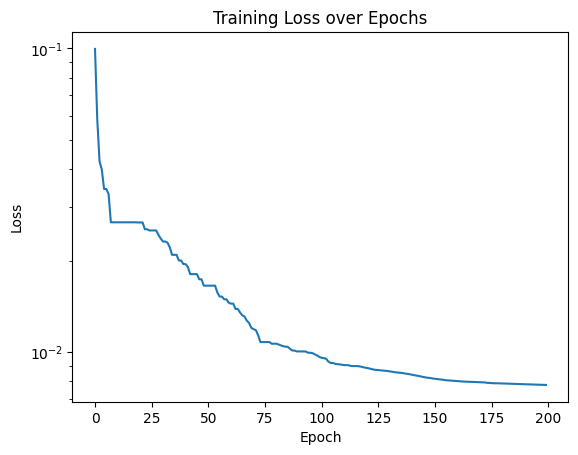

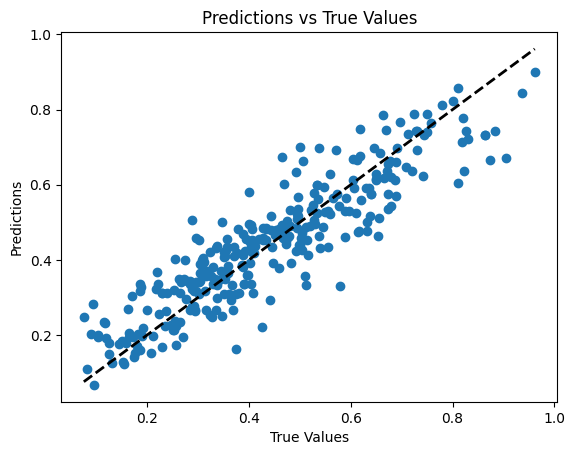

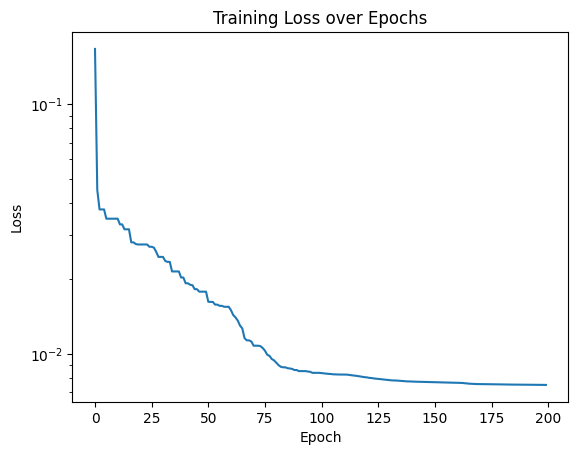

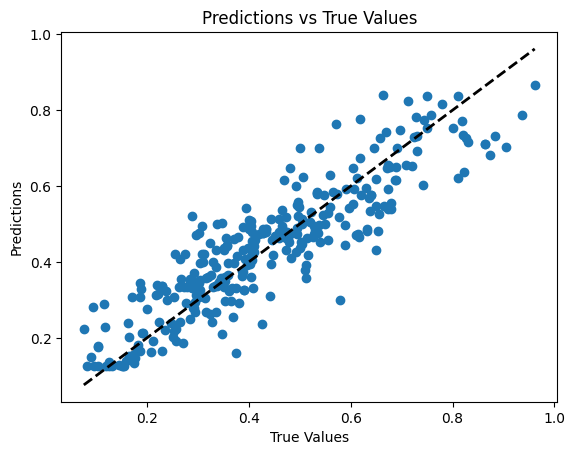

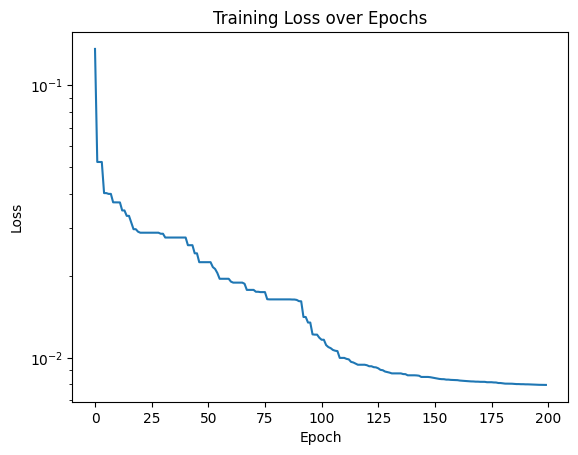

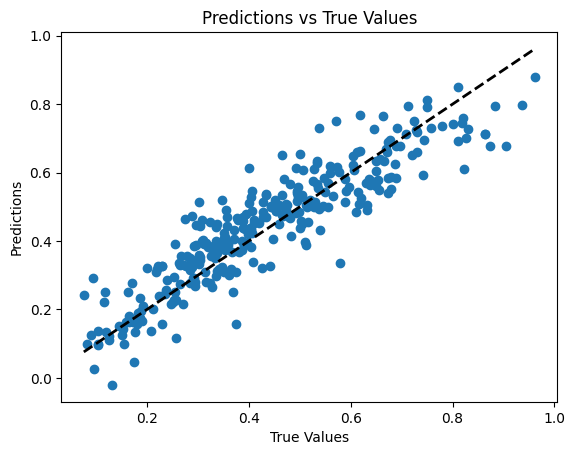

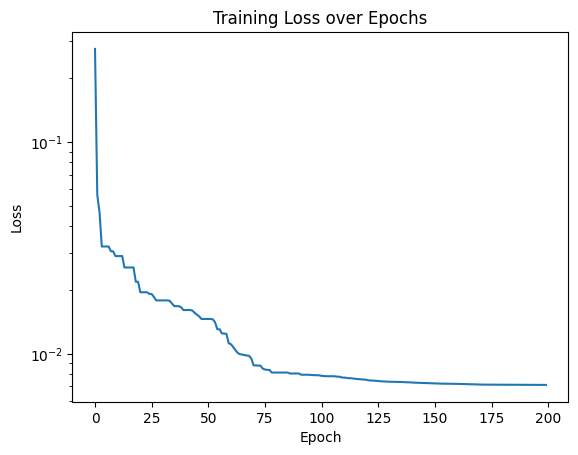

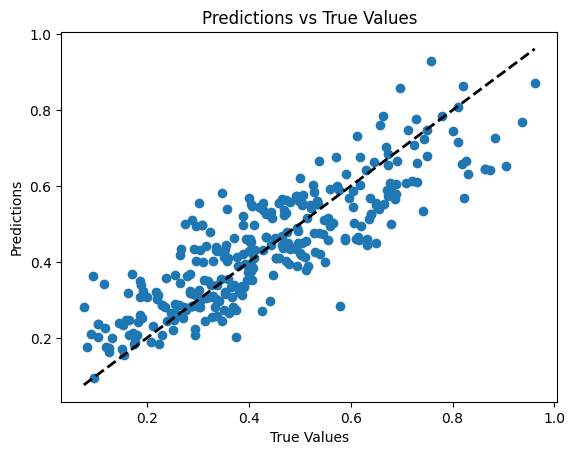

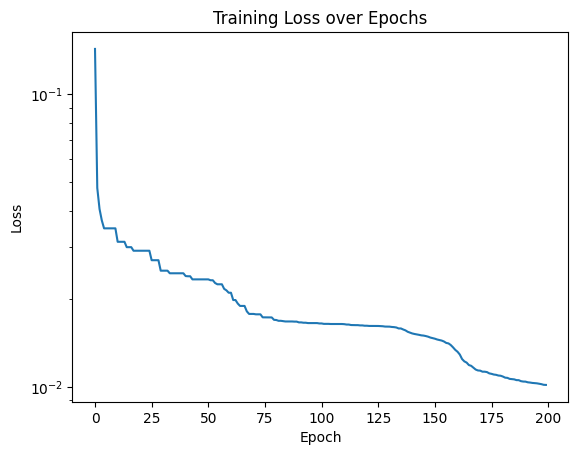

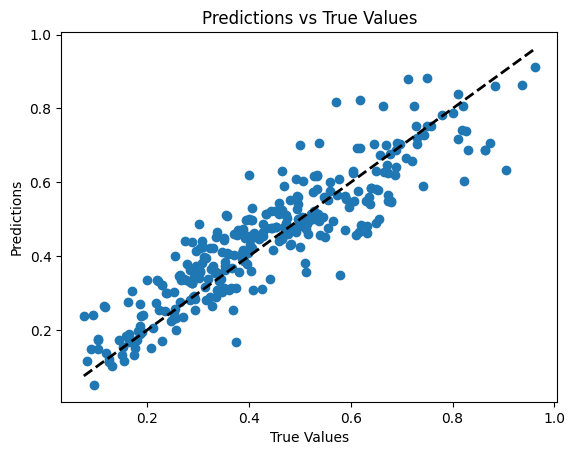

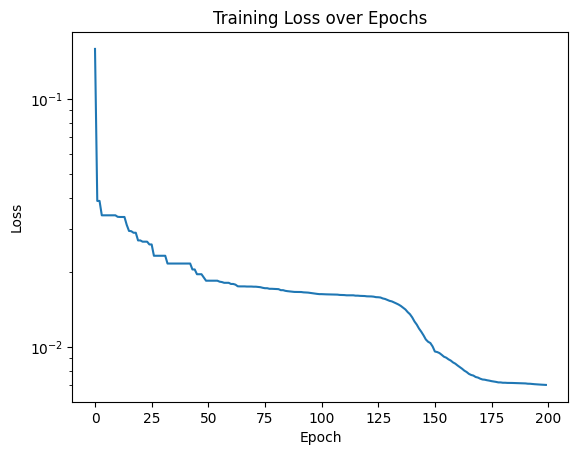

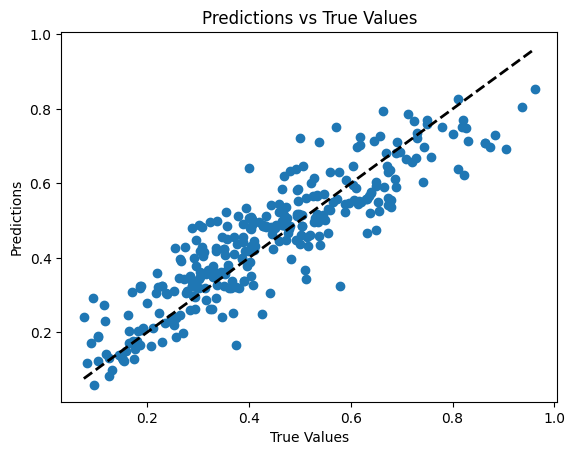

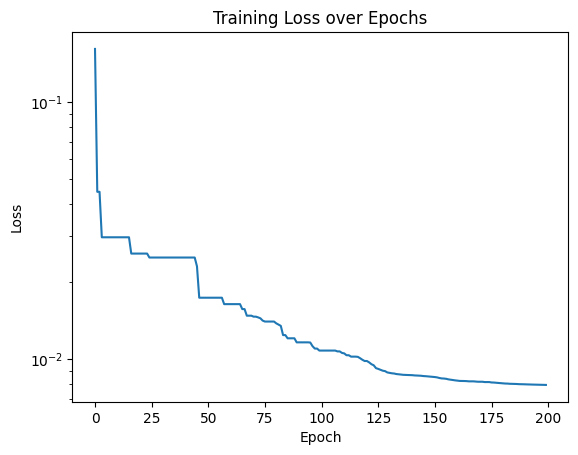

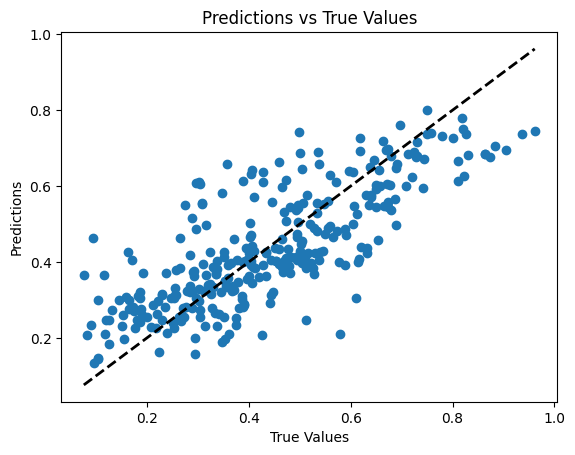

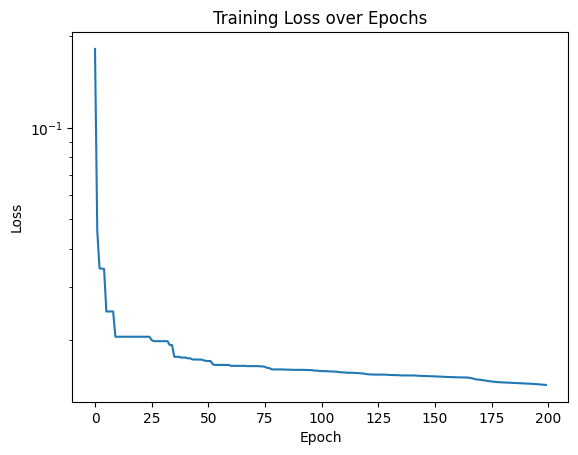

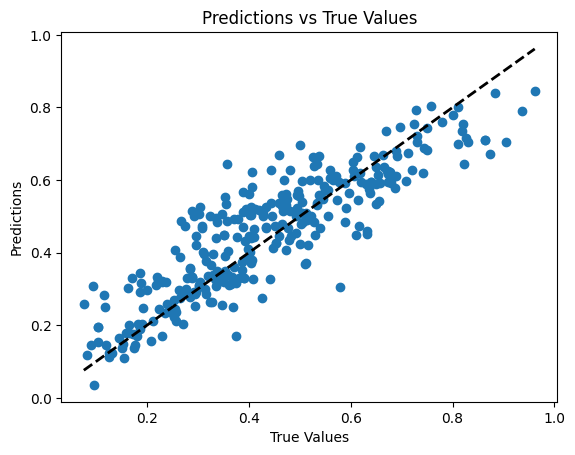

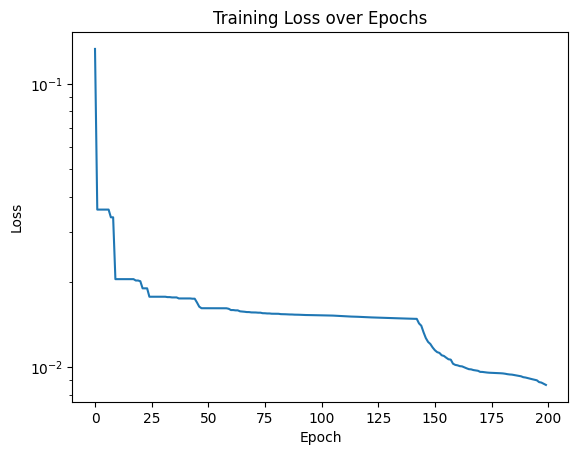

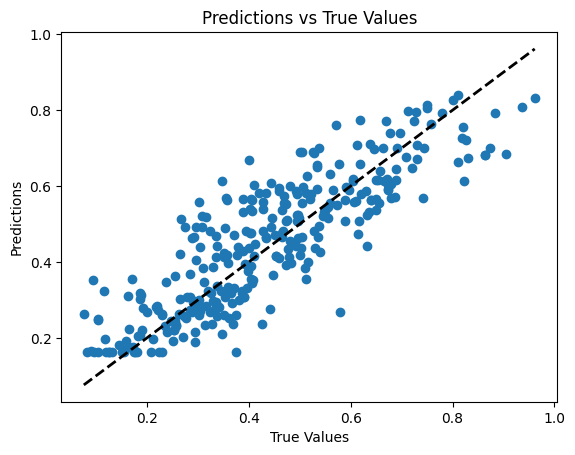

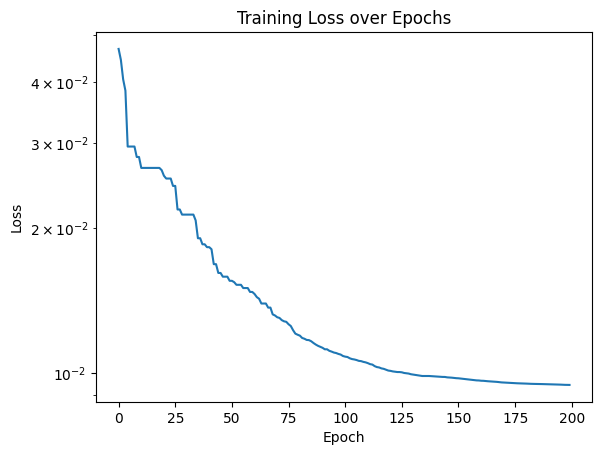

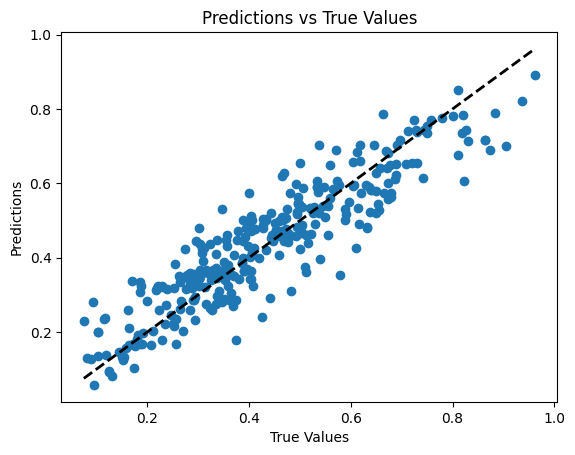

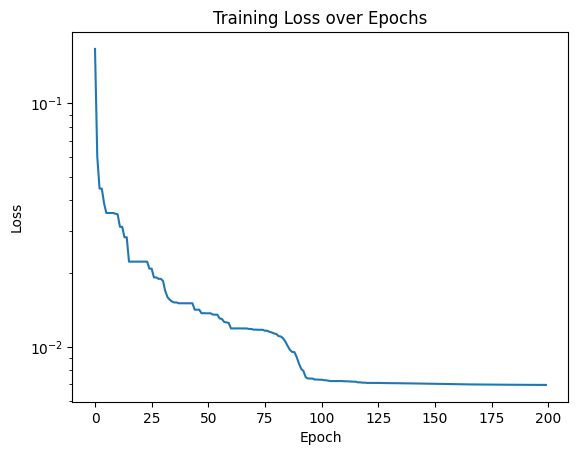

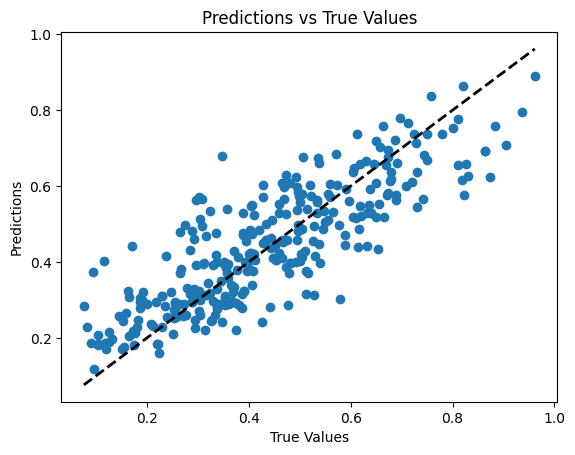

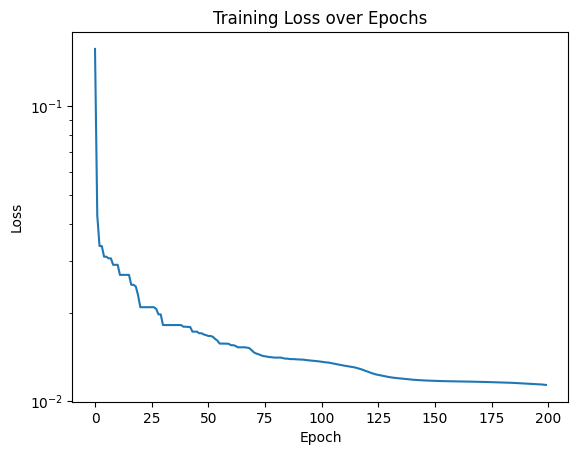

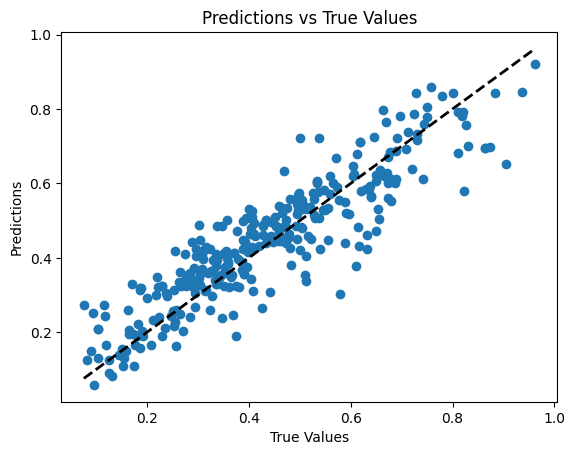

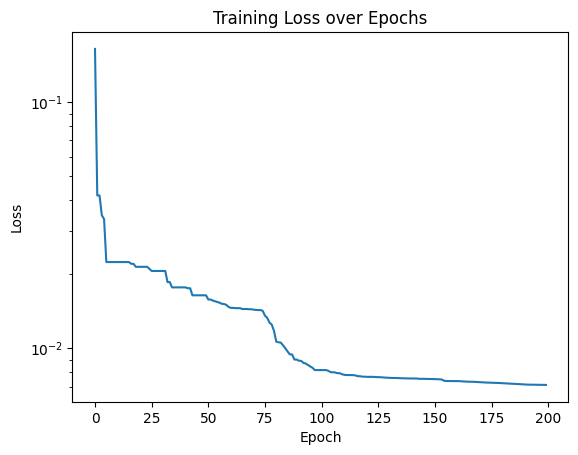

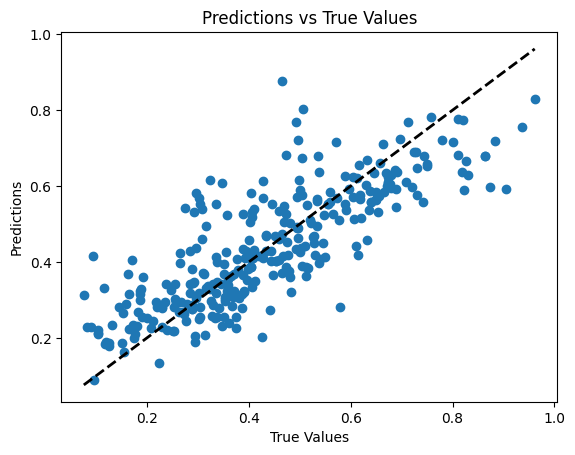

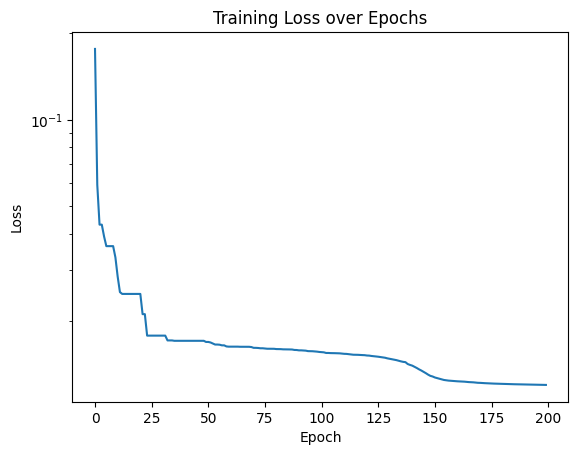

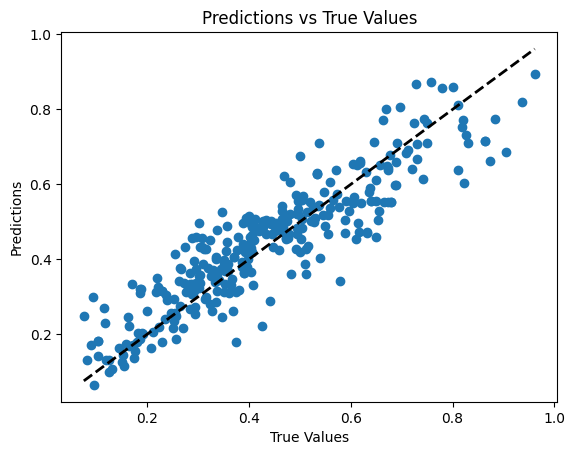

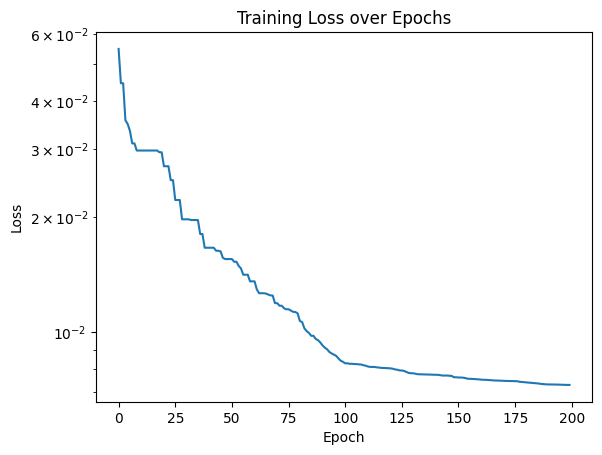

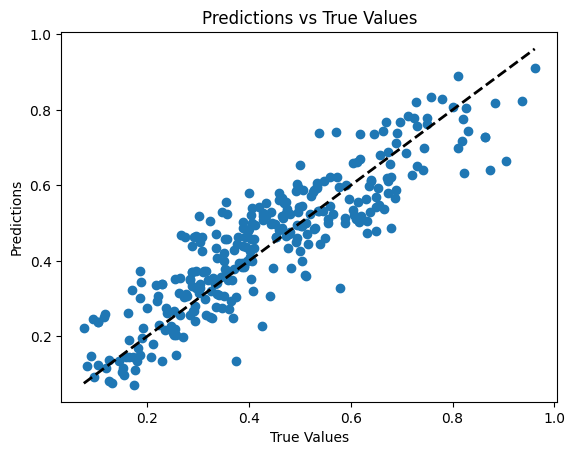

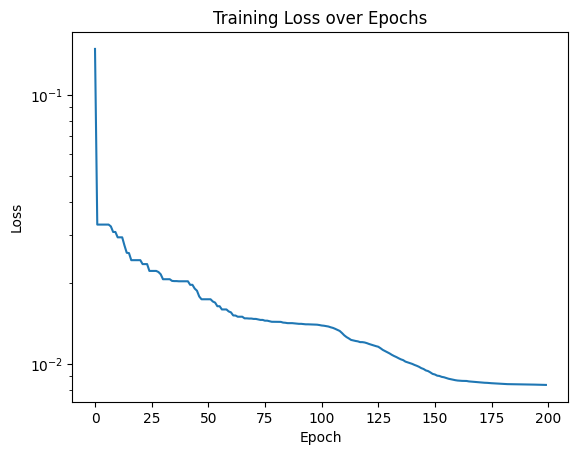

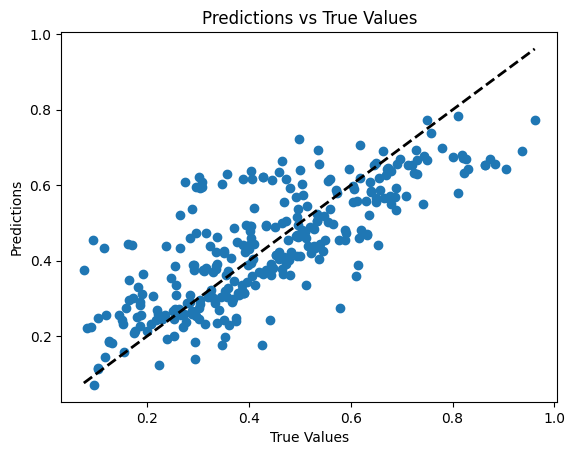

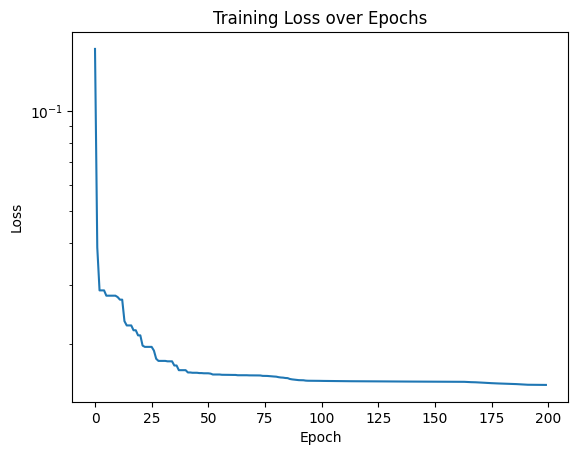

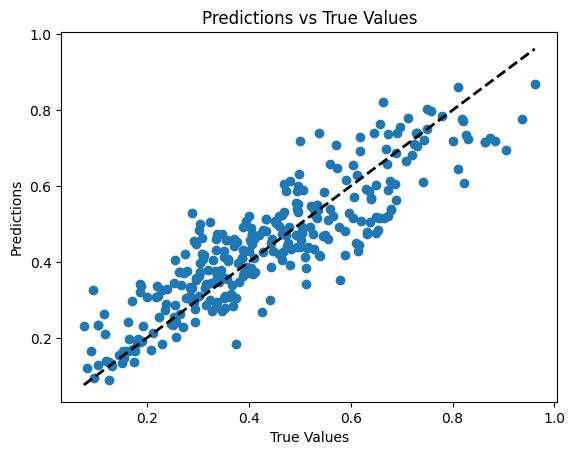

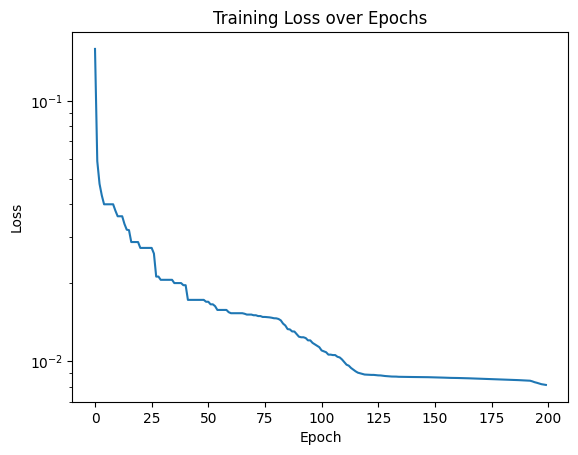

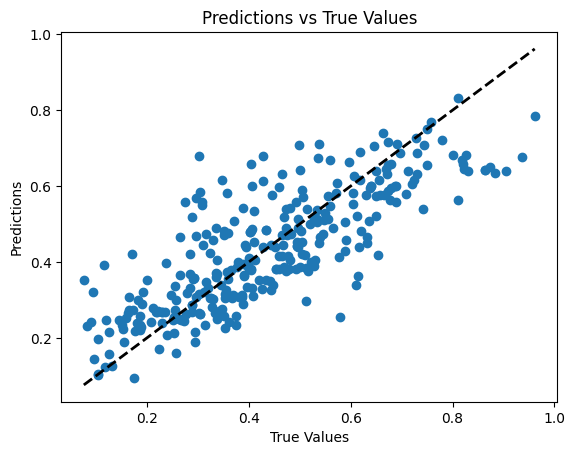

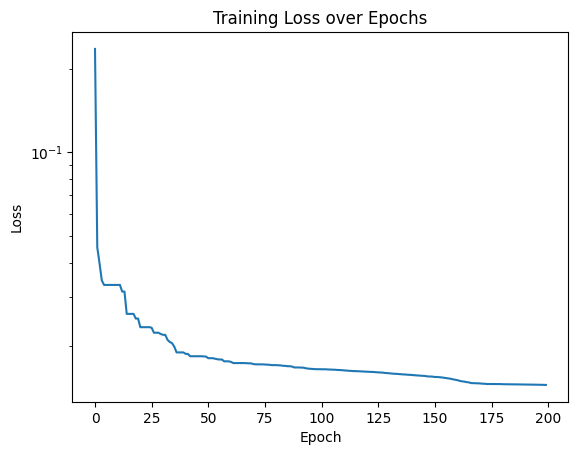

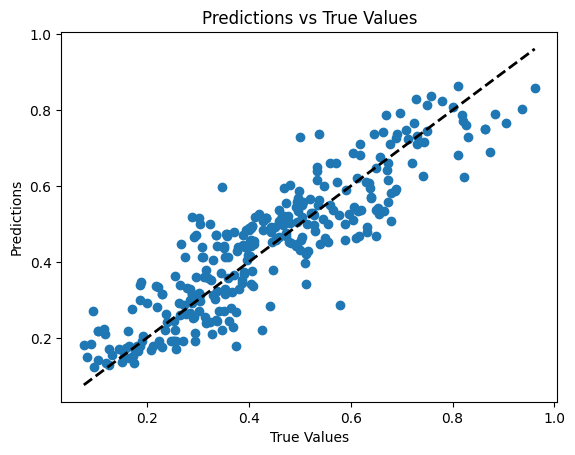

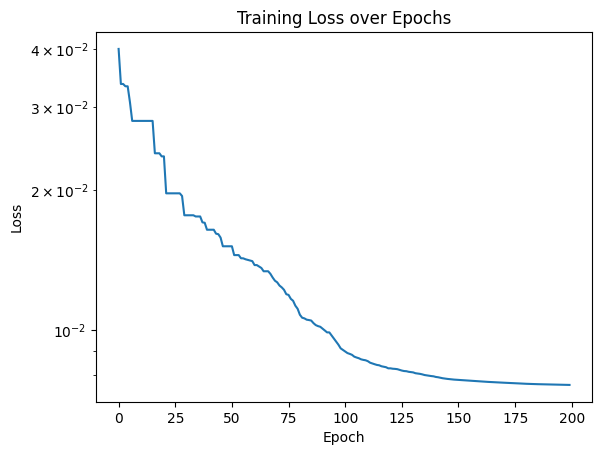

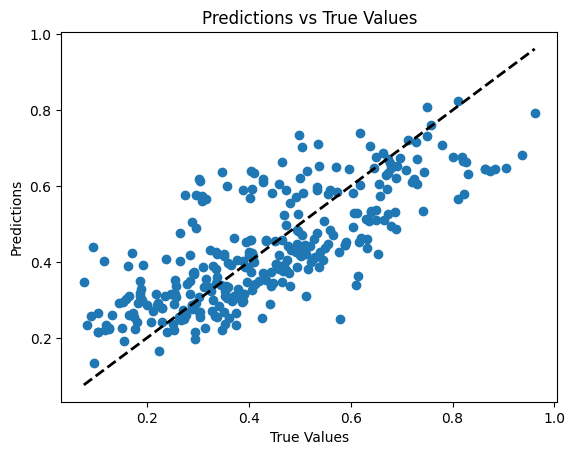

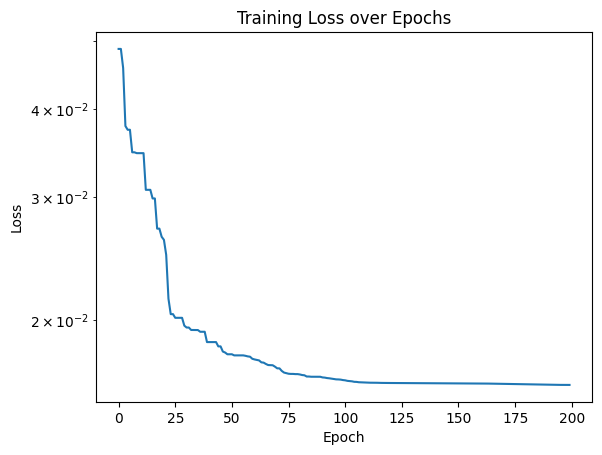

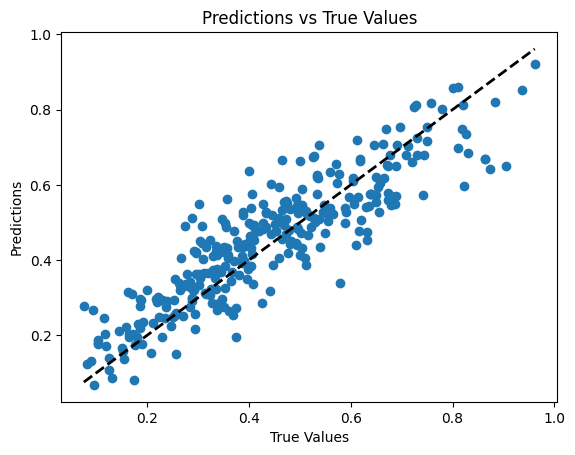

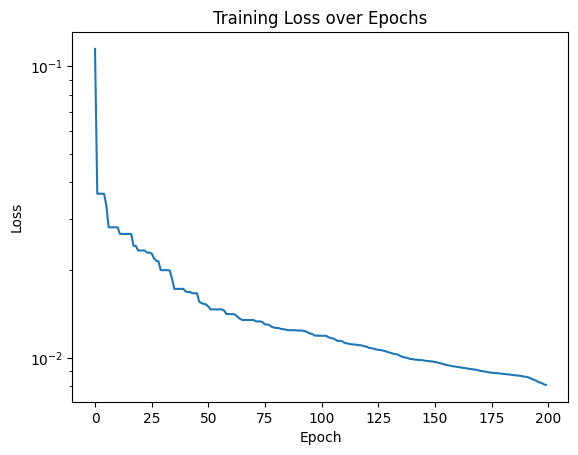

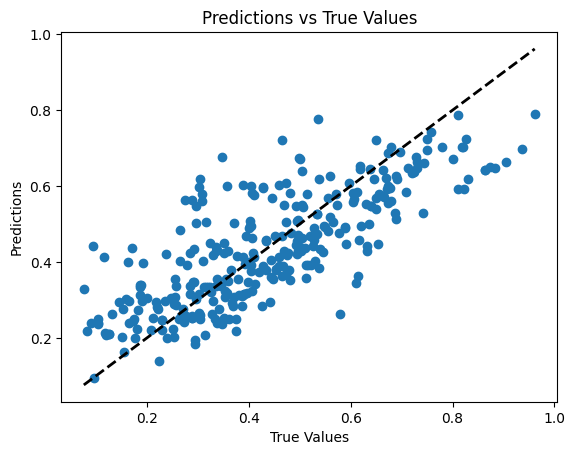

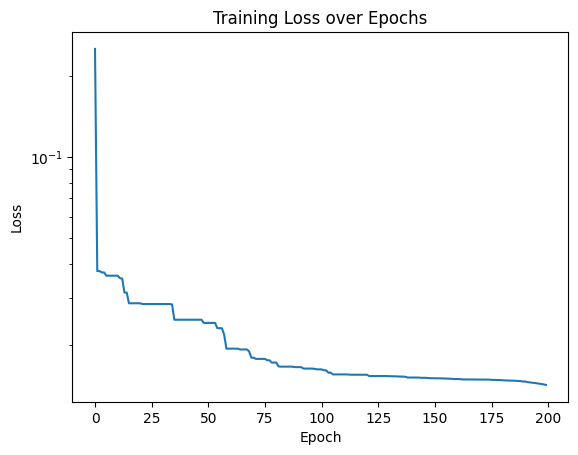

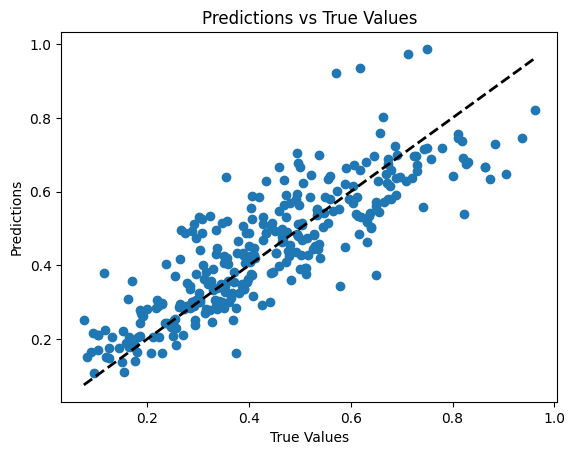

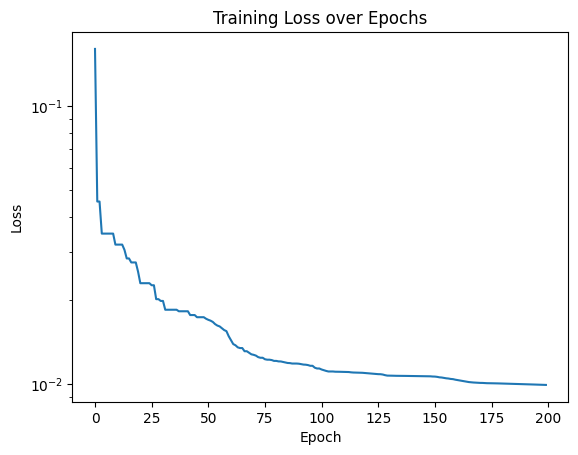

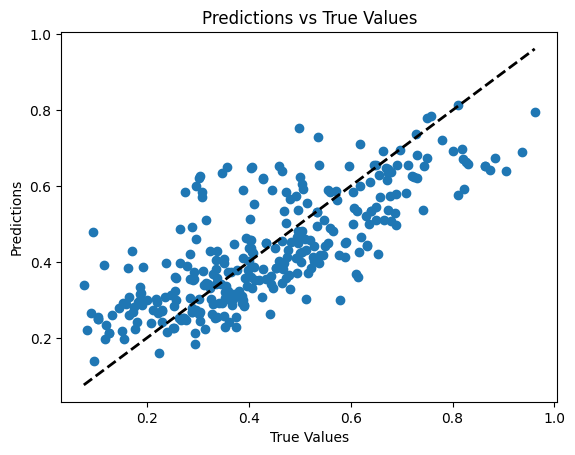

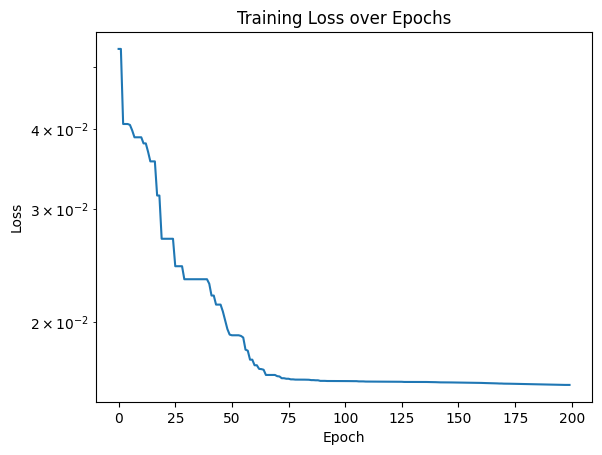

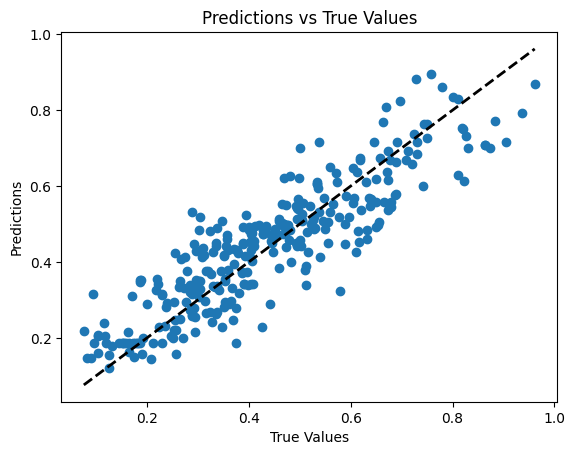

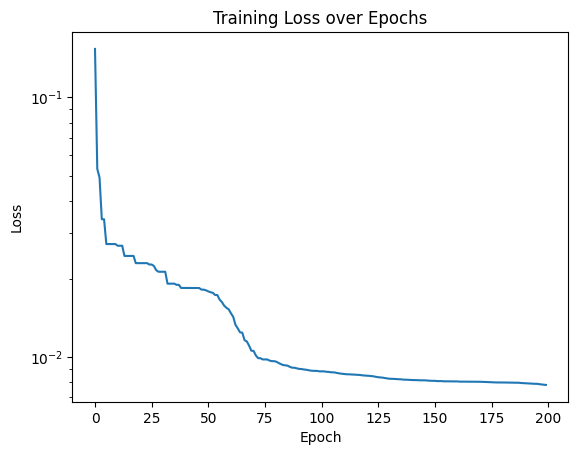

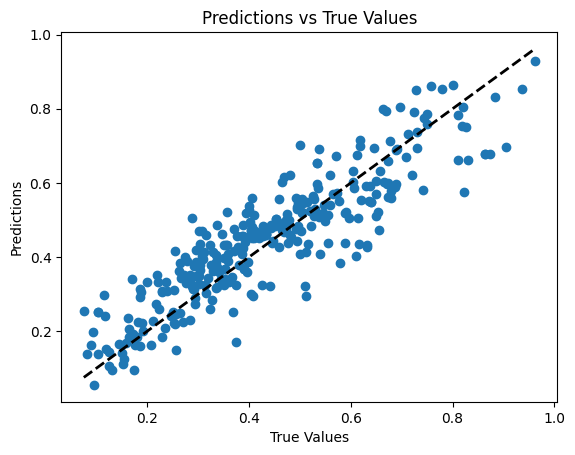

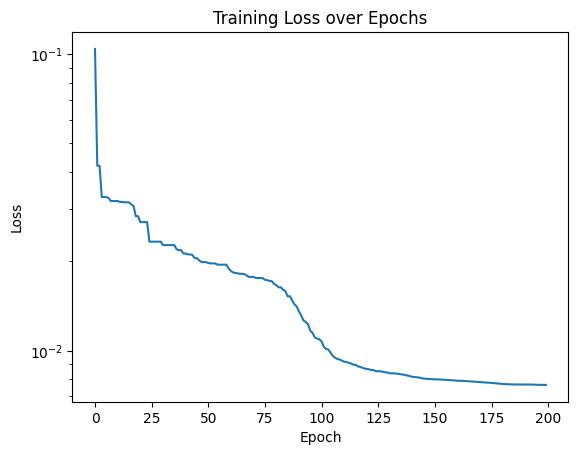

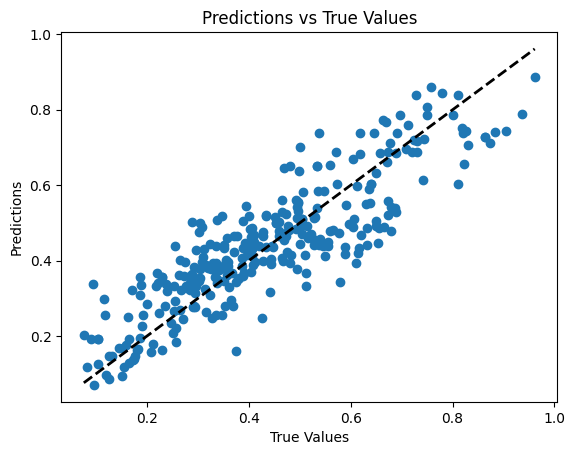

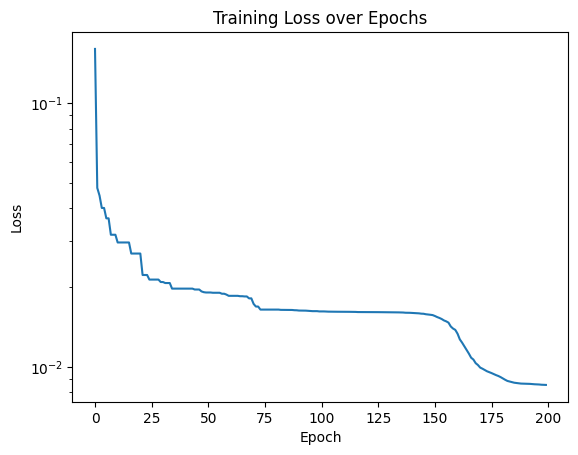

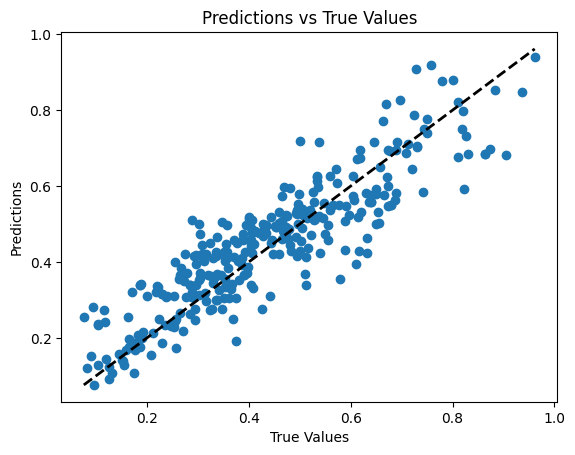

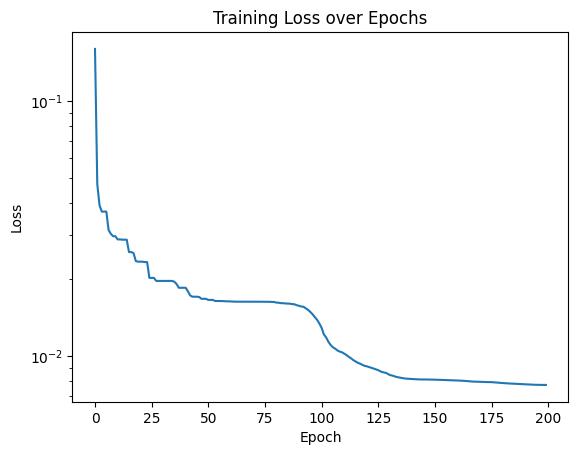

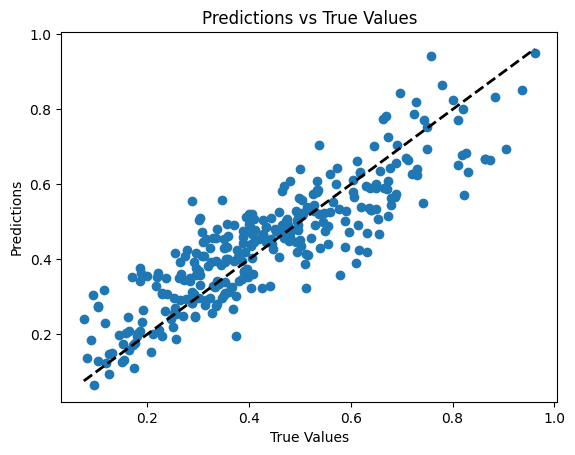

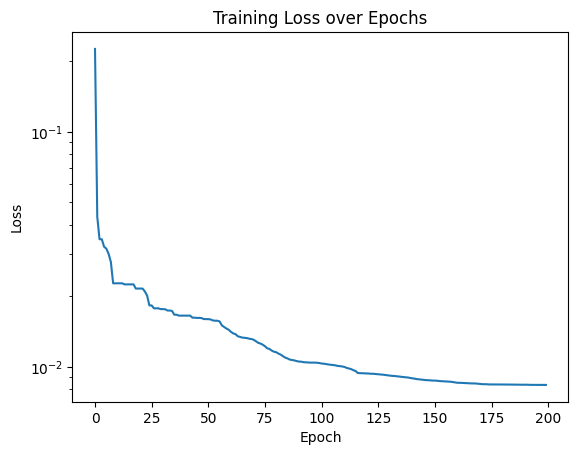

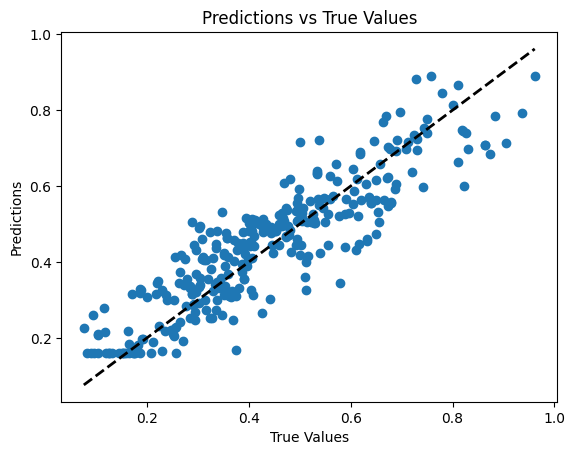

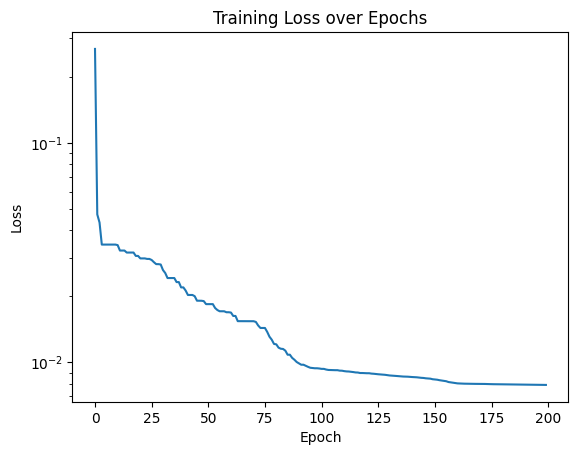

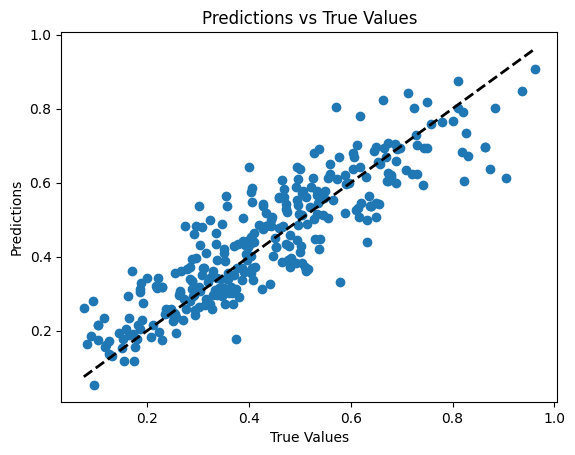

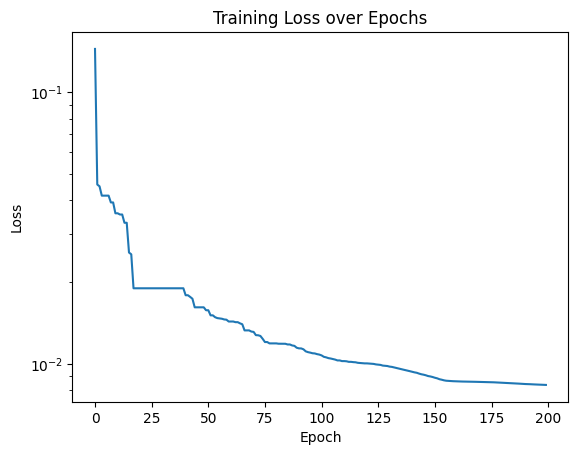

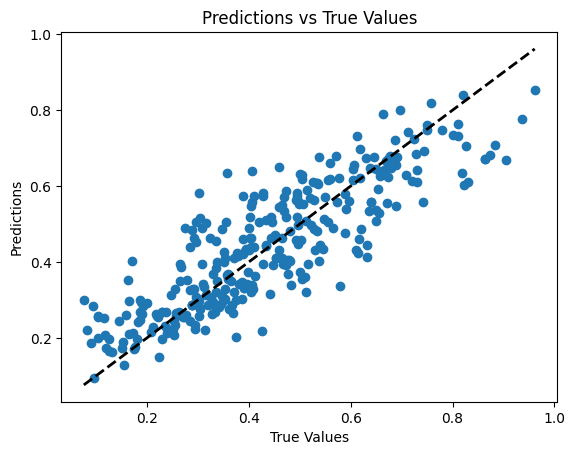

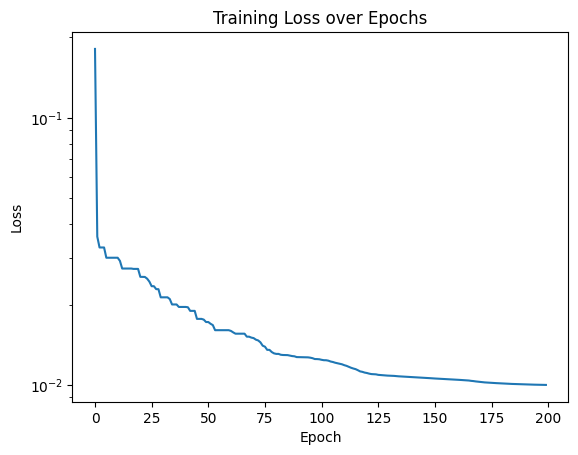

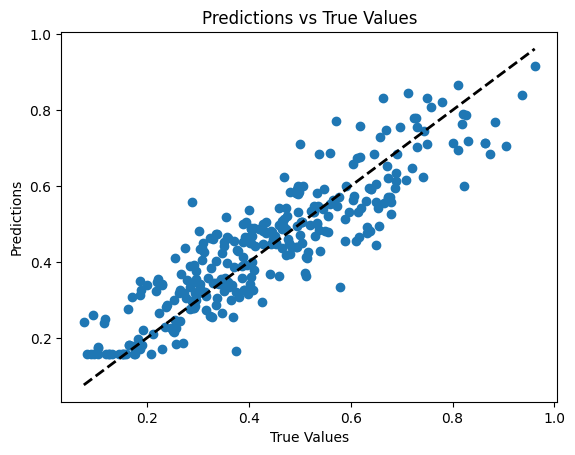

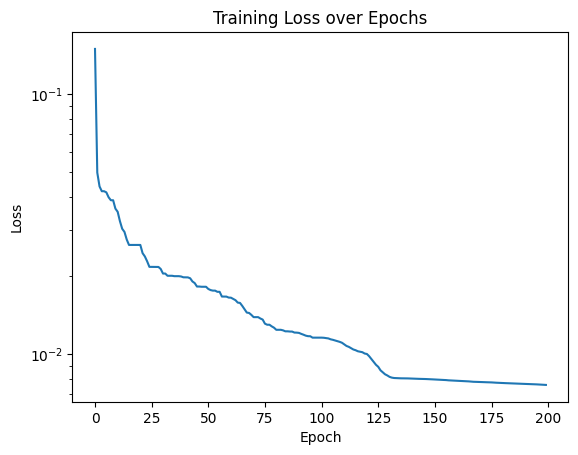

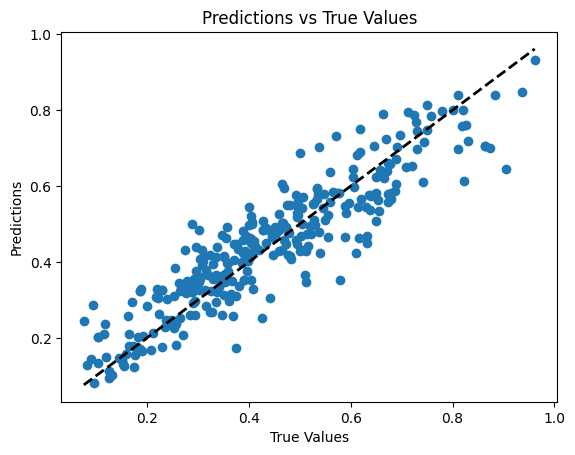

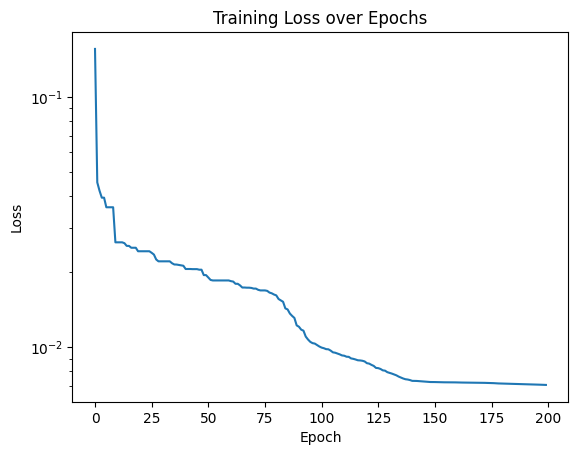

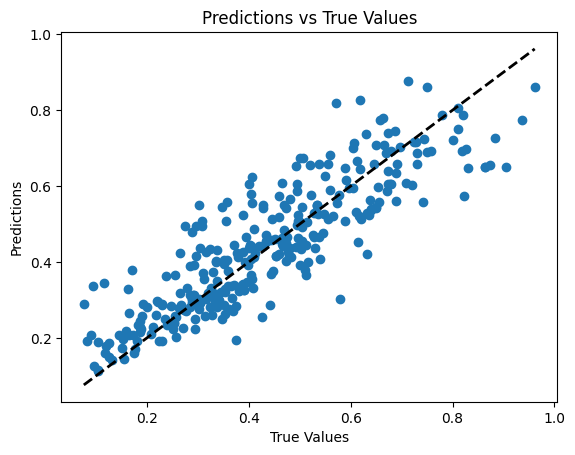

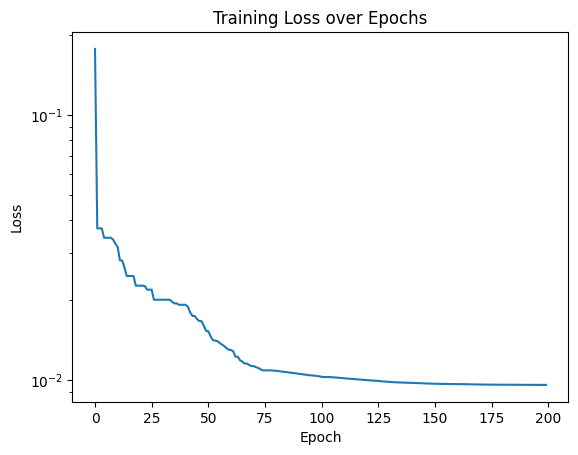

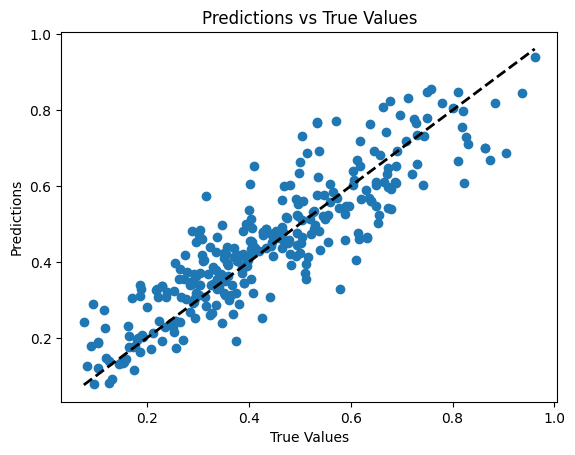

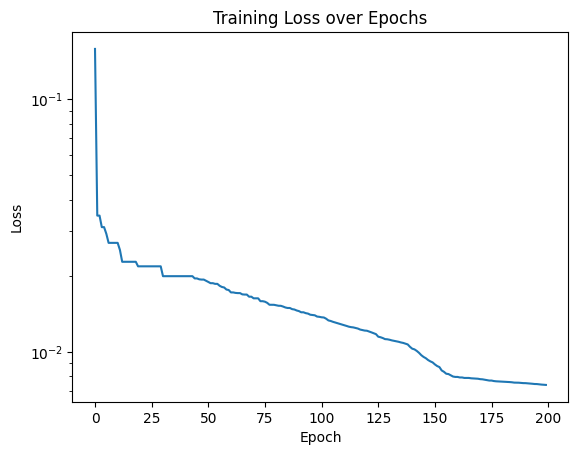

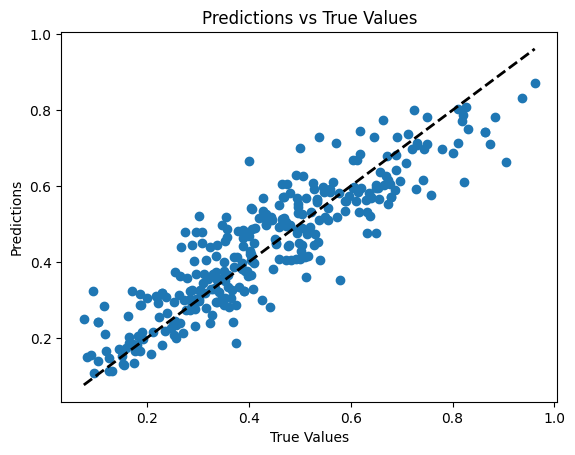

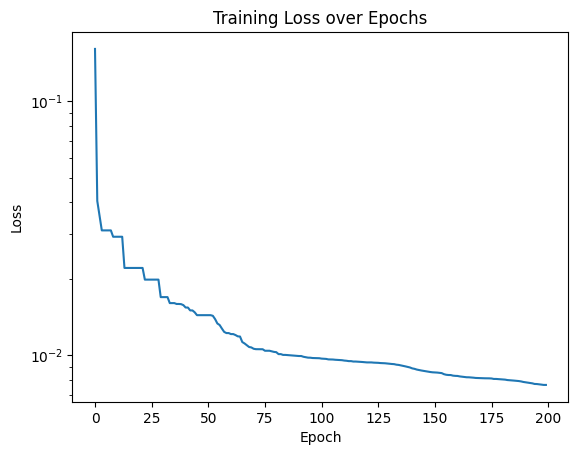

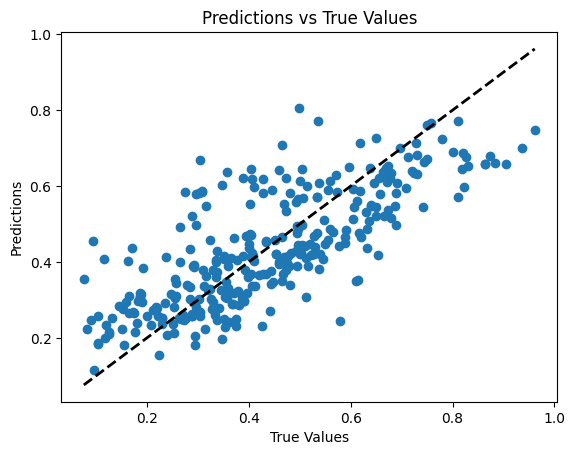

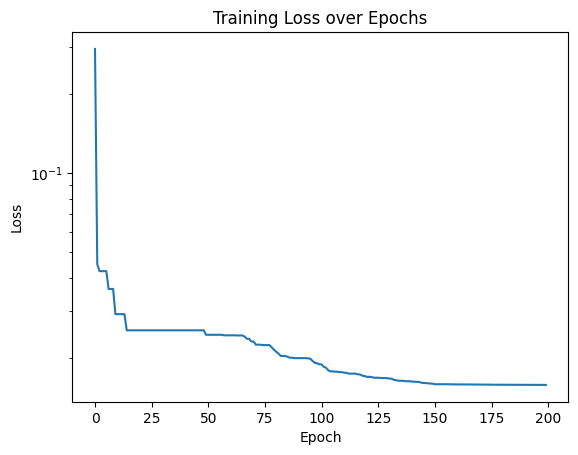

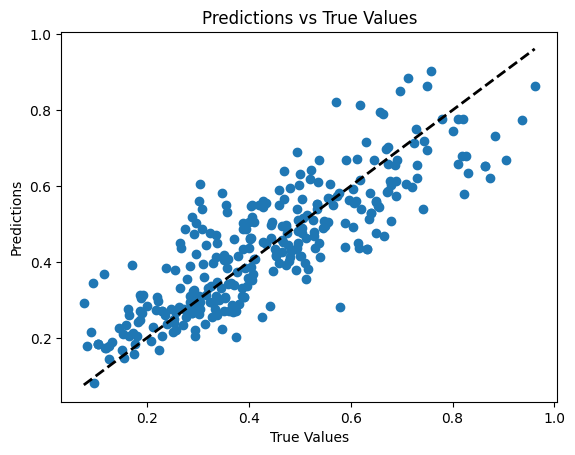

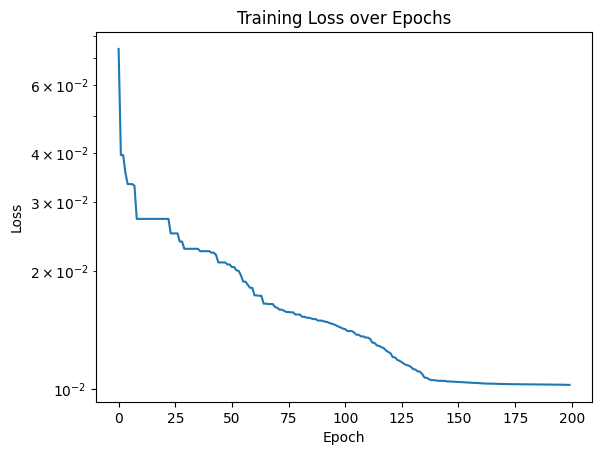

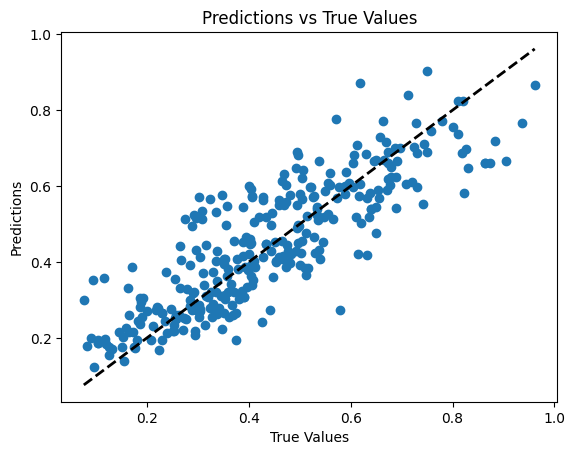

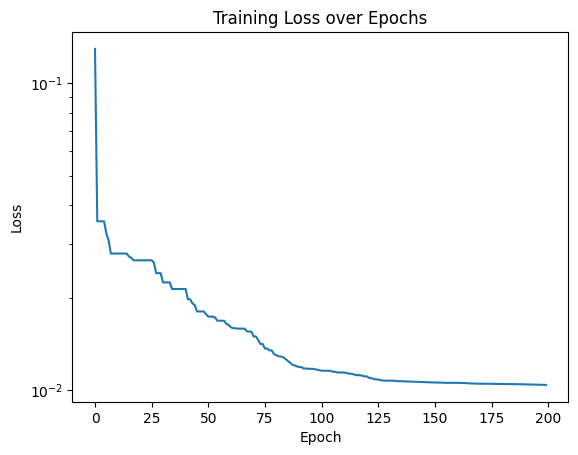

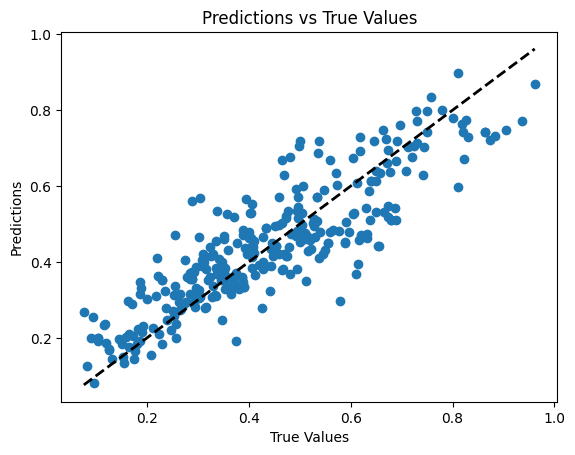

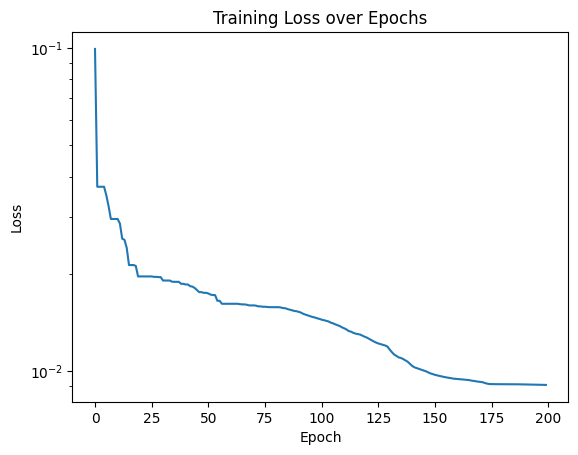

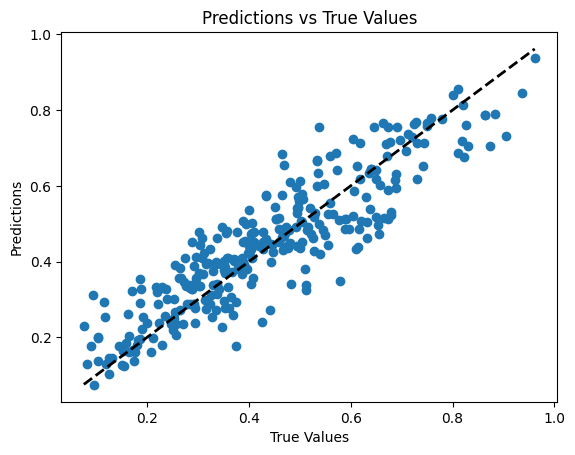

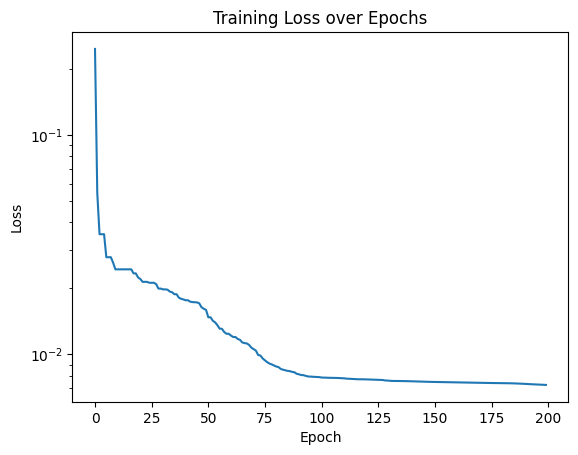

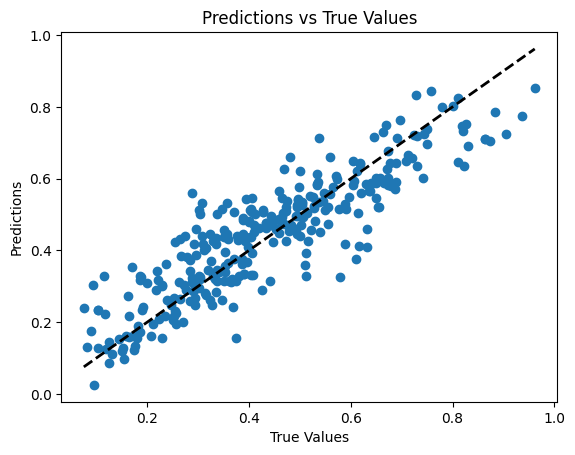

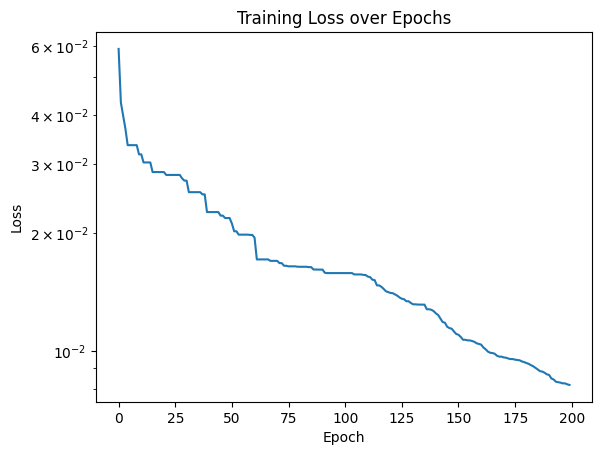

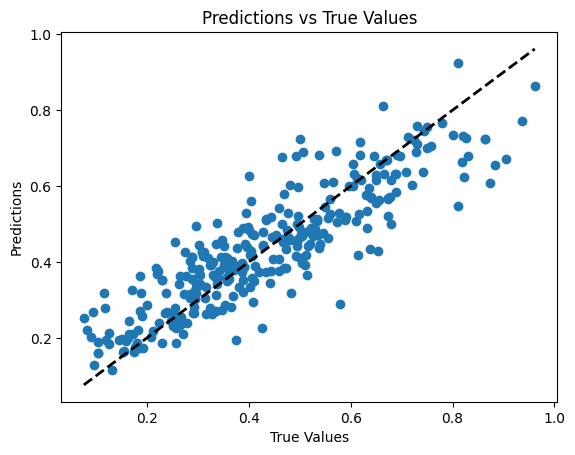

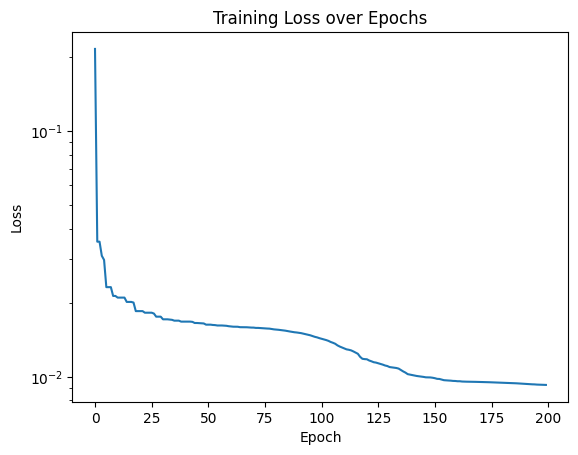

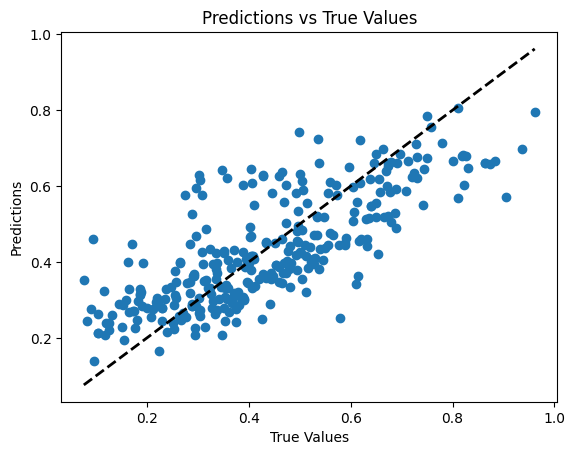

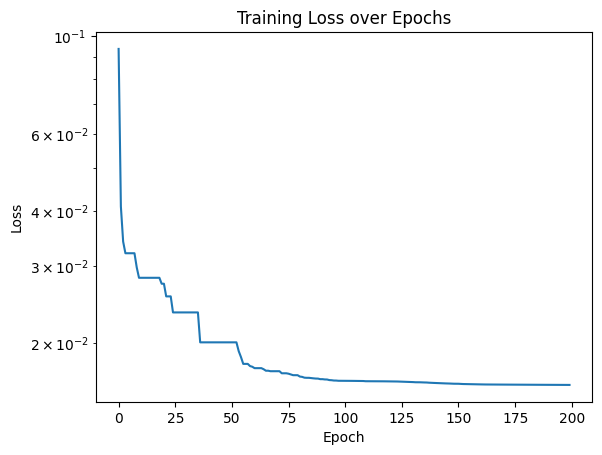

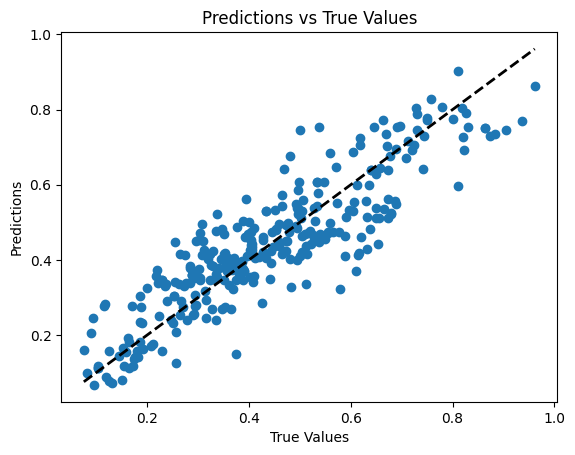

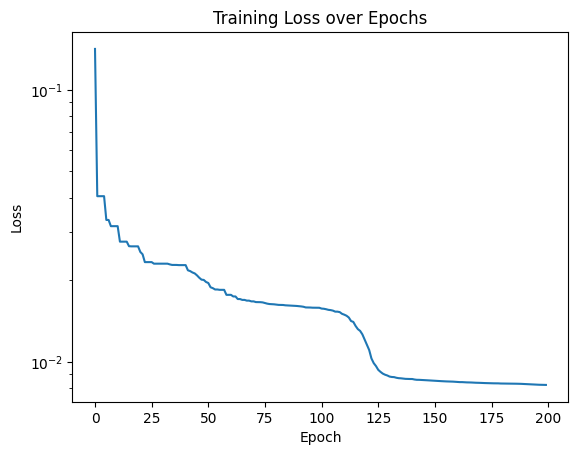

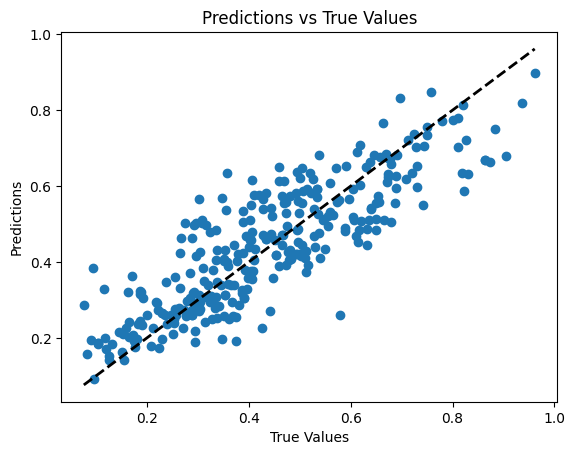

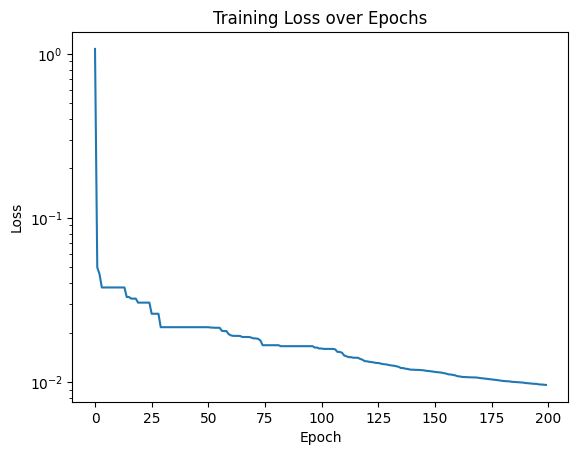

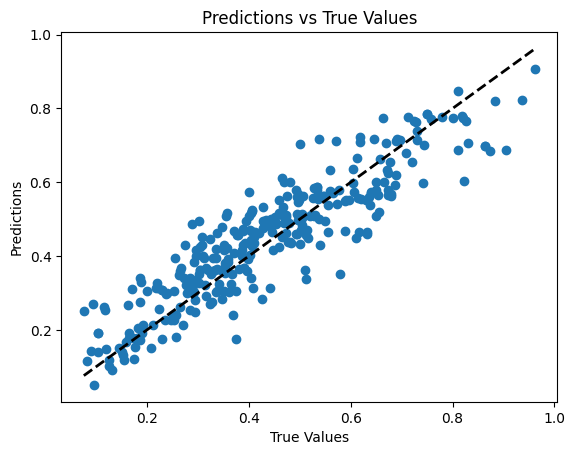

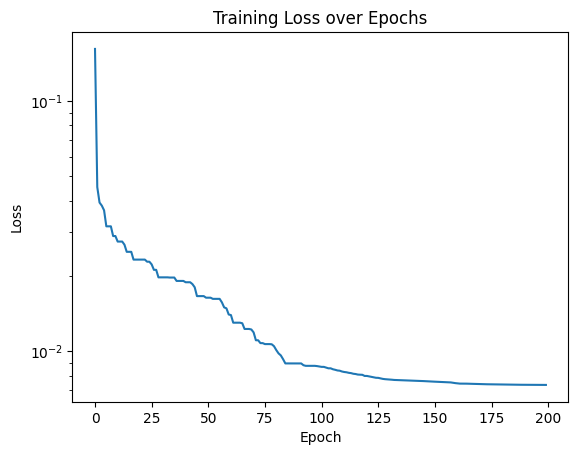

In [ ]:
print("OS: ", os.name)
if os.name == "posix":
    multiprocessing.set_start_method("fork", force=True)

# Load data
(train_features, train_targets), (test_features, test_targets) = load_data("./data/concrete_data.csv")

# Experiment parameters
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
size = [8, 4]
iter = 8
epochs = 200


# MLP
mlp = Sequential(
    Linear(size_input=train_features.shape[1], size_hidden=size[0]),
    ActivationReLU(),
    Linear(size_input=size[0], size_hidden=size[1]),
    ActivationReLU(),
    Linear(size_input=size[1], size_hidden=1),
)

# PSO hyperparameters
swarm_size = 48
accel_coeff = AccelerationCoefficients(
    inertia_weight=0.708,
    cognitive_weight=1.906,
    social_weight=0.288,
    global_best_weight=1.3,
    jump_size=0.760,
    max_velocity=0.9,
    max_position=3.87,
)
num_informants = 6
particle_initial_position_scale = (0.036145, 0.0893)
loss_function = mean_squared_error
informants_strategy = InformantStrategy.KNEAREST

# Main output directory
main_dir = f"./results/ga_test/{timestamp}_{size[0]}_{size[1]}_{iter}_iter_{epochs}_epoch"
os.makedirs(main_dir, exist_ok=True)

def run_single_iteration(run_id, train_features, train_targets, test_features, test_targets, epochs):
    # Seed for randomness
    seed = int.from_bytes(os.urandom(4), 'little') + run_id
    np.random.seed(seed)
    random.seed(seed)

    # PSO
    pso = ParticleSwarmOptimisation(
        X=train_features.T,
        Y=train_targets,
        swarm_size=swarm_size,
        accel_coeff=accel_coeff,
        num_informants=num_informants,
        informants_strategy=informants_strategy,
        loss_function=loss_function,
        particle_initial_position_scale=particle_initial_position_scale,
        model=mlp,
    )

    final_position, final_score, losses = pso.train(epochs)

    mlp.from_vector(final_position)
    predictions = mlp.forward(test_features.T)

    train_acc = pso.get_accuracy(train_features.T, train_targets)
    test_acc = pso.get_accuracy(test_features.T, test_targets)

    print(f"Run {run_id} completed: Final Loss = {final_score:.5f}, Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")

    return {
        "run": run_id,
        "loss": final_score,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "predictions": predictions,
        "losses": losses,
    }

if __name__ == "__main__":
    num_workers = multiprocessing.cpu_count()
    print(f"Running {iter} iterations in parallel using {num_workers} CPU cores...")

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(
                run_single_iteration,
                run_id,
                train_features, train_targets,
                test_features, test_targets,
                epochs
            )
            for run_id in range(1, iter + 1)
        ]
        results = [f.result() for f in futures]

    # --- Collect results ---
    all_final_losses = [res["loss"] for res in results]
    all_final_train_accuracies = [res["train_acc"] for res in results]
    all_final_test_accuracies = [res["test_acc"] for res in results]

    # --- Summary statistics ---
    avg_loss = np.mean(all_final_losses)
    avg_train_acc = np.mean(all_final_train_accuracies)
    avg_test_acc = np.mean(all_final_test_accuracies)
    std_train_acc = np.std(all_final_train_accuracies)
    std_test_acc = np.std(all_final_test_accuracies)

    print(f"\n===== Summary over {iter} runs =====")
    print(f"Average loss: {avg_loss:.4f}")
    print(f"Average train accuracy: {avg_train_acc:.2f}%")
    print(f"Average test accuracy:  {avg_test_acc:.2f}%")
    print(f"Train accuracy std: {std_train_acc:.2f}")
    print(f"Test accuracy std:  {std_test_acc:.2f}")

    # --- Save summary to file ---
    summary_path = f"{main_dir}/experiment_summary.txt"
    with open(summary_path, "w") as f:
        f.write("===== GLOBAL EXPERIMENT SUMMARY =====\n\n")
        f.write(f"=== PSO Hyperparameters ===\n")
        f.write(f"Swarm size: 48\nEpochs: {epochs}\n")
        f.write(f"Inertia: {accel_coeff.inertia_weight}\nCognitive: {accel_coeff.cognitive_weight}\n")
        f.write(f"Social: {accel_coeff.social_weight}\nGlobal best: {accel_coeff.global_best_weight}\n")
        f.write(f"Jump size: {accel_coeff.jump_size}\nMax velocity: {accel_coeff.max_velocity}\n")
        f.write(f"Max position: {accel_coeff.max_position}\nInformants: {num_informants}\n")
        f.write(f"Initial position scale: {particle_initial_position_scale}\n\n")
        f.write(f"=== RESULTS OVER {iter} RUNS ===\n")
        for res in results:
            f.write(f"Run {res['run']}: Loss = {res['loss']:.5f}, "
                    f"Train Acc = {res['train_acc']:.2f}%, "
                    f"Test Acc = {res['test_acc']:.2f}%\n")
        f.write("\n=== Averages ===\n")
        f.write(f"Average Loss: {avg_loss:.6f}\n")
        f.write(f"Average Train Accuracy: {avg_train_acc:.2f}%\n")
        f.write(f"Average Test Accuracy: {avg_test_acc:.2f}%\n\n")
        f.write("=== Standard Deviations ===\n")
        f.write(f"Std Train Acc: {std_train_acc:.2f}\n")
        f.write(f"Std Test Acc: {std_test_acc:.2f}\n")

    # Generate plots

    # Train accuracy histogram
    plt.hist(all_final_train_accuracies, bins=10, edgecolor='black')
    plt.title("Distribution of Test Accuracies over PSO Runs")
    plt.xlabel("Train Accuracy (%)")
    plt.ylabel("Run")
    plt.savefig(f"{main_dir}/train_accuracy_distribution.png")
    plt.show()

    # Test accuracy histogram
    plt.hist(all_final_test_accuracies, bins=10, edgecolor='black')
    plt.title("Distribution of Test Accuracies over PSO Runs")
    plt.xlabel("Test Accuracy (%)")
    plt.ylabel("Run")
    plt.savefig(f"{main_dir}/test_accuracy_distribution.png")
    plt.show()

    dir = f"{main_dir}/predictions_vs_true_values"
    os.makedirs(dir, exist_ok=True)
    dir = f"{main_dir}/training_loss_over_epochs"
    os.makedirs(dir, exist_ok=True)

    for res in results:
        plt.scatter(test_targets, res["predictions"])
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.title("Predictions vs True Values")
        plt.plot(
            [test_targets.min(), test_targets.max()],
            [test_targets.min(), test_targets.max()],
            "k--",
            lw=2,
        )
        plt.savefig(f"{main_dir}/predictions_vs_true_values/{res['run']}.png")
        plt.show()

        plt.plot(res["losses"])
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.savefig(f"{main_dir}/training_loss_over_epochs/{res['run']}.png")
        plt.show()